# Reverse-time and Kirchhoff migration

By Adonis JAMAL and Jean-Vincent MARTINI

The goal is to generate synthetic data and plot the images obtained by Reverse-Time migration in diﬀerent two-dimensional conﬁgurations, and to study the resolution and stability properties of the method with respect to measurement noise, and to compare with other methods.

---
## 1) Preliminaries

We assume that the medium has speed of propagation $c_0 = 1$. The homogeneous two-dimensional Green's function $\hat{G}_0(\omega, x, y)$ is solution of $$\Delta_x \hat{G}_0 + \omega^2 \hat{G}_0 = -\delta(x-y), \quad x \in \mathbb{R}^2$$ with the Sommerfeld radiation condition. It is given by $$\hat{G}_0(\omega, x, y) = \frac{i}{4} H_0^{(1)}(\omega |x-y|)$$ where $H_0^{(1)}$ is the Hankel function $$H_0^{(1)}(s) = J_0(s) + i Y_0(s)$$ and $J_0$ is the Bessel function of the first kind of order zero and $Y_0$ is the Bessel function of the second kind of order zero.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel1, j0
from time import time
from tqdm import tqdm
from ipywidgets import interact, FloatSlider

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

---
## 2) Time-harmonic localization - full aperture

Consider $N$ transducers on a circular array centered at $0$ with radius $R_0$. Consider a point-like reflector at $x_{ref}$.

Generate the dataset, i.e. the matrix of the time-harmonic amplitudes $\hat{u}_{rs}(\omega)$ recorded by the $r$-th receiver when the $s$-th source emits a time-harmonic signal with unit amplitude and frequency $\omega$. Use a Born approximation for the reflector to generate the data.

Give the forms of the (two-dimensional) RT and KM imaging functional $\mathcal{I}_{RT}(x)$ and $\mathcal{I}_{KM}(x)$, and plot them using the data set.

Compare the focal spot with the theoretical function $J_0^2(\omega |x-x_{ref}|)$ (give a proof of this formula).

Use $\omega = 2\pi$, $R_0 = 100$, $N = 100$, and $x_{ref} = (10, 20)$, and play with the numbers (in particular, move the reflector).

<blockquote>

### Theoretical analysis

Since the transducers are placed on a circular array centered at $\mathbf{0}$ with radius $R_0$, the position of each transducer can be expressed in the form $\bm{x}_t = R_0 (\cos \theta_t, \sin \theta_t)$, where $\theta_t=\frac{2\pi (t-1)}{N}$ for $t=1,2,...,N$.

When a source $s$ emits a time-harmonic signal at frequency $\omega$, the signal recorded at the position $\bm{x}$ can be expressed using the Green's function as:
$$\hat{u}_{s}(\omega, \bm{x}) = \hat{G}_0(\omega, \bm{x}, \bm{x}_s) = \frac{i}{4} H_0^{(1)}(\omega |\bm{x}-\bm{x}_s|).$$

A point-like reflector at $\bm{x}_{ref}$ is modeled with $\delta(\bm{x}-\bm{x}_{ref})$. Using the Born approximation, the filed measured at the receiver $r$ due to the source $s$ can be expressed as:
$$\hat{u}_{rs}(\omega) = \omega^2 \int_{\mathbb{R}^2} \hat{G}_0(\omega, \bm{x}_r, \bm{x}) \delta(\bm{x}-\bm{x}_{\text{ref}}) \hat{G}_0(\omega, \bm{x}, \bm{x}_s) \, d\bm{x} = \omega^2 \hat{G}_0(\omega, \bm{x}_r, \bm{x}_{\text{ref}}) \hat{G}_0(\omega, \bm{x}_{\text{ref}}, \bm{x}_s).$$

Using the explicit expression of the Green's function, we have:
\begin{align*}
\hat{u}_{rs}(\omega)
&= \omega^2 \left(\frac{i}{4}\right)^2 H_0^{(1)}(\omega |\bm{x}_r - \bm{x}_{\text{ref}}|) H_0^{(1)}(\omega |\bm{x}_{\text{ref}} - \bm{x}_s|) \\
&= -\frac{\omega^2}{16} H_0^{(1)}(\omega |\bm{x}_r - \bm{x}_{\text{ref}}|) H_0^{(1)}(\omega |\bm{x}_{\text{ref}} - \bm{x}_s|)
\end{align*}

Since our transducers are both sources and receivers, we can write the $\hat{u}_{rs}(\omega)$ as a $N \times N$ data matrix where each entry corresponds to the measurement at receiver $r$ due to source $s$. By defining $v_t = H_0^{(1)}(\omega |\bm{x}_t - \bm{x}_{\text{ref}}|)$, for $t=1,2,...,N$, since our indexes $r$ and $s$ are interchangeable, we can express the data matrix as:
$$\hat{U}(\omega) = -\frac{\omega^2}{16} \mathbf{v} \mathbf{v}^T,$$
where $\mathbf{v} = (v_1, v_2, ..., v_N)^T$.

Reverse-Time (RT) migration and Kirchhoff Migration (KM) are two imaging techniques used to reconstruct the location of the reflector from the measured data. The Kirchhoff migration is obtained as a simplification of the reverse-time imaging function in which we take $\hat{G}_0 (\omega, \bm{x}, \bm{y}) \approx \exp{[i\omega \mathcal{T}(\bm{x}, \bm{y})]}$, $\mathcal{T}(\bm{x}, \bm{y})$ is the travel time from $\bm{x}$ to $\bm{y}$. The imaging functionals for RT and KM can be defined as follows:
$$\mathcal{I}_{RT}(\bm{x}) = \frac{1}{2\pi} \int_{-\infty}^{\infty} d\omega \sum_{r=1}^N \sum_{s=1}^N \overline{\hat{G}_0(\omega, \bm{x}, \bm{x}_r)} \hat{u}_{rs}(\omega) \overline{\hat{G}_0(\omega, \bm{x}_s, \bm{x})},$$
$$\mathcal{I}_{KM}(\bm{x}) = \frac{1}{2\pi} \int_{-\infty}^{\infty} d\omega \sum_{r=1}^N \sum_{s=1}^N e^{-i\omega|\bm{x} - \bm{x}_r|} \hat{u}_{rs}(\omega) e^{-i\omega|\bm{x}_s - \bm{x}|}.$$

At a single frequency $\omega$, we can simplify these functionals to:
$$\mathcal{I}_{RT}(\bm{x}) = \sum_{r=1}^N \sum_{s=1}^N \overline{\hat{G}_0(\omega, \bm{x}, \bm{x}_r)} \hat{u}_{rs}(\omega) \overline{\hat{G}_0(\omega, \bm{x}_s, \bm{x})},$$
$$\mathcal{I}_{KM}(\bm{x}) = \sum_{r=1}^N \sum_{s=1}^N e^{-i\omega|\bm{x} - \bm{x}_r|} \hat{u}_{rs}(\omega) e^{-i\omega|\bm{x}_s - \bm{x}|}.$$

By substituting the expression of $\hat{u}_{rs}(\omega)$ into the imaging functionals, we can express them as a square magnitude of a sum involving the function $H_0^{(1)}$ and its complex conjugate, up to a multiplicative constant. Specifically, we have:
$$\mathcal{I}_{RT}(\bm{x}) \propto \left| \sum_{t=1}^N \overline{H_0^{(1)}(\omega |\bm{x}-\bm{x}_t|)} H_0^{(1)}(\omega |\bm{x}_t - \bm{x}_{\text{ref}}|) \right|^2,$$
$$\mathcal{I}_{KM}(\bm{x}) \propto \left| \sum_{t=1}^N e^{-i\omega|\bm{x} - \bm{x}_t|} H_0^{(1)}(\omega |\bm{x}_t - \bm{x}_{\text{ref}}|) \right|^2.$$

Since the Hankel function $H_0^{(1)}$ can be approximated by $H_0^{(1)}(s) \approx \sqrt{\frac{2}{\pi s}} e^{i(s - \frac{\pi}{4})}$, the term $e^{-i\omega|\bm{x} - \bm{x}_t|}$ in the KM functional can be seen as an approximation of $\overline{H_0^{(1)}(\omega |\bm{x}-\bm{x}_t|)}$ in the RT functional. Therefore, in this particular configuration, we can see that $\mathcal{I}_{RT}(\bm{x}) \approx \mathcal{I}_{KM}(\bm{x})$ for all $\bm{x}$.

Next, we will prove that, at the focal spot, the imaging functional behaves like $\mathcal{I}(\bm{x}) \sim J_0^2(\omega |\bm{x}-\bm{x}_{\text{ref}}|)$, where $J_0$ is the Bessel function of the first kind of order zero. 

As the number of transducers $N\to\infty$, uniformly distributed on the circle $\Gamma_{R_0}$ of radius $R_0$, the discrete sum in the imaging functional converges to the following integral:
$$
\mathcal{I}(\bm{x})\propto
\left|
\int_{\Gamma_{R_0}}
\overline{H_0^{(1)}\big(\omega|\bm{x}-\bm{y}|\big)}
H_0^{(1)}\big(\omega|\bm{x}_{\mathrm{ref}}-\bm{y}|\big)
\,d\sigma(\bm{y})
\right|^2,
$$
where $d\sigma$ denotes the arc-length measure on $\Gamma_{R_0}$.

Using the far-field approximation $R_0=|\bm{y}|>>1$, the phase terms dominate: $$ \overline{H_0^{(1)}\big(\omega|\bm{x}-\bm{y}|\big)} H_0^{(1)}\big(\omega|\bm{x}_{\mathrm{ref}}-\bm{y}|\big) \approx \frac{2}{\pi \omega R_0} e^{-i\omega|\bm{x}-\bm{y}|} e^{i\omega|\bm{x}_{\mathrm{ref}}-\bm{y}|}$$

We approximate the phase difference: $$|\bm{x}_\mathrm{ref}-\bm{y}| - |\bm{x}-\bm{y}| \approx \frac{y}{|\bm{y}|} \cdot (\bm{x}-\bm{x}_{\mathrm{ref}})$$

Let $y = R_0 (\cos \theta, \sin \theta)$ and $x - x_{\mathrm{ref}} = \Delta x$. Then the phase is $k \cos (\theta - \phi) |\Delta x|$ where $\phi$ is the angle of $\Delta x$. Therefore, the integral over the circle becomes: $$ \int_0^{2\pi} e^{i \omega \frac{y}{R_0} \cdot (x - x_\mathrm{ref})} d\theta = 2\pi J_0(\omega |\bm{x}-\bm{x}_{\mathrm{ref}}|)$$

Squaring the result gives us the final resolution profile: $$\mathcal{I}(\bm{x}) \propto J_0^2(\omega |\bm{x}-\bm{x}_{\mathrm{ref}}|)$$

<blockquote>

In [32]:
# Parameters
N = 100  # Number of transducers
w = 2 * np.pi  # Frequency
R0 = 100  # Array radius
x_ref = (10, 20)  # Point-like reflector position

theta_t = np.linspace(0, 2 * np.pi, N, endpoint=False)  # Angles for transducers
x_t = np.stack(
    (R0 * np.cos(theta_t), R0 * np.sin(theta_t)), axis=-1
)  # Transducer positions

# Grid parameters for imaging
n = 400
xlim = (-125, 125)
zlim = (-125, 125)
x = np.linspace(xlim[0], xlim[1], n)
z = np.linspace(zlim[0], zlim[1], n)
X, Z = np.meshgrid(x, z)

# Define zoom window size
zoom_half_width = 20

x_zoom = (x_ref[0] - zoom_half_width, x_ref[0] + zoom_half_width)
z_zoom = (x_ref[1] - zoom_half_width, x_ref[1] + zoom_half_width)

In [33]:
# Green's function
def GreenRT(dist, omega=w):
    """Green's function for Reverse-Time Migration."""
    return (1j / 4) * hankel1(0, omega * dist)


def GreenKM(dist, omega):
    """Green's function for Kirchhoff Migration."""
    return np.exp(-1j * omega * dist)

In [34]:
# Generate data matrix using Born approximation
dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
v_t = GreenRT(dist_t_ref, w)
U = -(w**2 / 16) * np.outer(v_t, v_t)

# Compute imaging functionals
I_RT = np.zeros_like(X, dtype=float)
I_KM = np.zeros_like(X, dtype=float)

for i in range(n):
    for j in range(n):
        X_ij = np.array([X[i, j], Z[i, j]])

        # Distances from transducers to current imaging point
        dists = np.linalg.norm(x_t - X_ij, axis=1)

        # Reverse-Time Migration
        g_rt = GreenRT(dists, w)
        vec_rt = np.conj(g_rt)
        sum_RT = vec_rt @ U @ vec_rt.T
        I_RT[i, j] = np.abs(sum_RT) ** 2

        # Kirchhoff Migration
        vec_km = GreenKM(dists, w)
        sum_KM = vec_km @ U @ vec_km.T
        I_KM[i, j] = np.abs(sum_KM) ** 2

dist = np.sqrt((X - x_ref[0]) ** 2 + (Z - x_ref[1]) ** 2)
I_TH = j0(w * dist) ** 2

# Normalize for better visualization
I_RT /= I_RT.max()
I_KM /= I_KM.max()
I_TH /= I_TH.max()

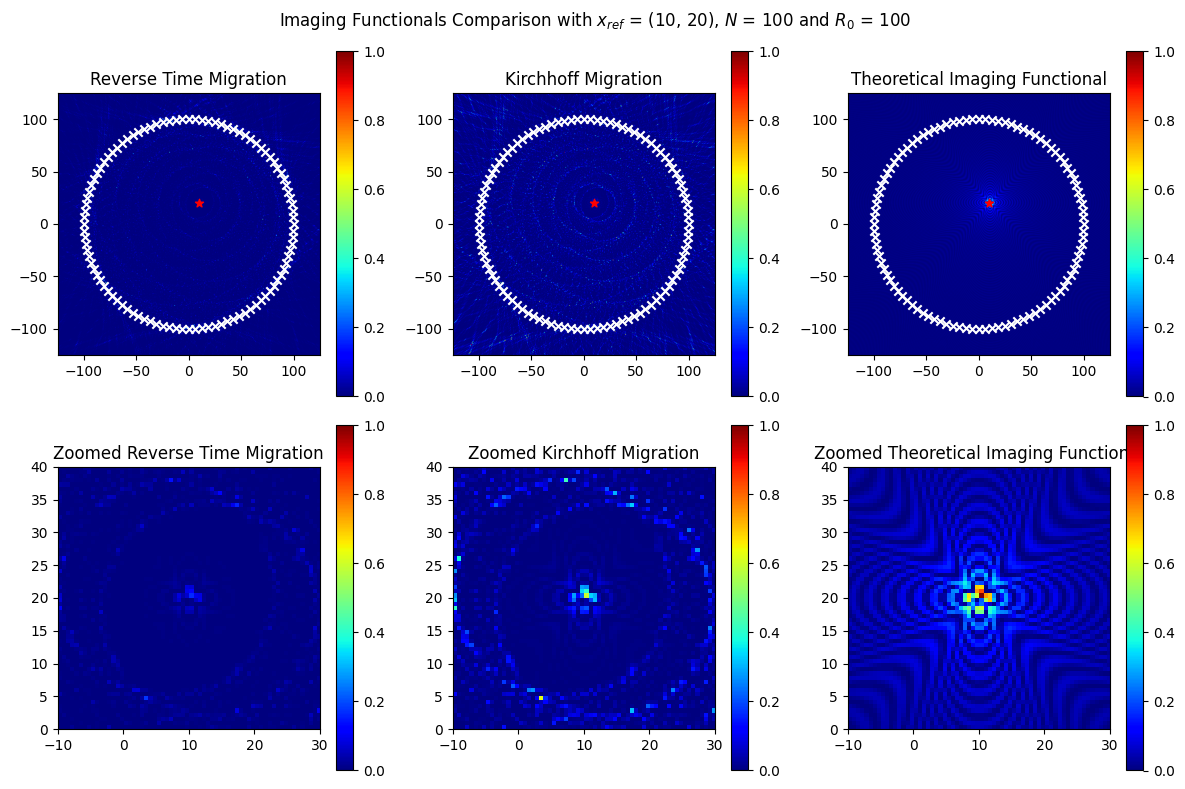

In [35]:
# Plot results
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

im0 = axes[0, 0].imshow(
    I_RT, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[0, 0].set_title("Reverse Time Migration")
axes[0, 0].scatter(x_ref[0], x_ref[1], color="red", marker="*", label="Reflector")
axes[0, 0].scatter(x_t[:, 0], x_t[:, 1], color="white", marker="x", label="Transducers")
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(
    I_KM, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[0, 1].set_title("Kirchhoff Migration")
axes[0, 1].scatter(x_ref[0], x_ref[1], color="red", marker="*", label="Reflector")
axes[0, 1].scatter(x_t[:, 0], x_t[:, 1], color="white", marker="x", label="Transducers")
plt.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].imshow(
    I_TH, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[0, 2].set_title("Theoretical Imaging Functional")
axes[0, 2].scatter(x_ref[0], x_ref[1], color="red", marker="*", label="Reflector")
axes[0, 2].scatter(x_t[:, 0], x_t[:, 1], color="white", marker="x", label="Transducers")
plt.colorbar(im2, ax=axes[0, 2])

im3 = axes[1, 0].imshow(
    I_RT, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[1, 0].set_title("Zoomed Reverse Time Migration")
axes[1, 0].set_xlim(x_zoom)
axes[1, 0].set_ylim(z_zoom)
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(
    I_KM, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[1, 1].set_title("Zoomed Kirchhoff Migration")
axes[1, 1].set_xlim(x_zoom)
axes[1, 1].set_ylim(z_zoom)
plt.colorbar(im4, ax=axes[1, 1])

im5 = axes[1, 2].imshow(
    I_TH, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[1, 2].set_title("Zoomed Theoretical Imaging Functional")
axes[1, 2].set_xlim(x_zoom)
axes[1, 2].set_ylim(z_zoom)
plt.colorbar(im5, ax=axes[1, 2])

fig.suptitle(
    f"Imaging Functionals Comparison with $x_{{ref}}$ = {x_ref}, $N$ = {N} and $R_0$ = {R0}"
)
plt.tight_layout()
plt.savefig("figures/Full_Aperture.png", dpi=300)
plt.show()

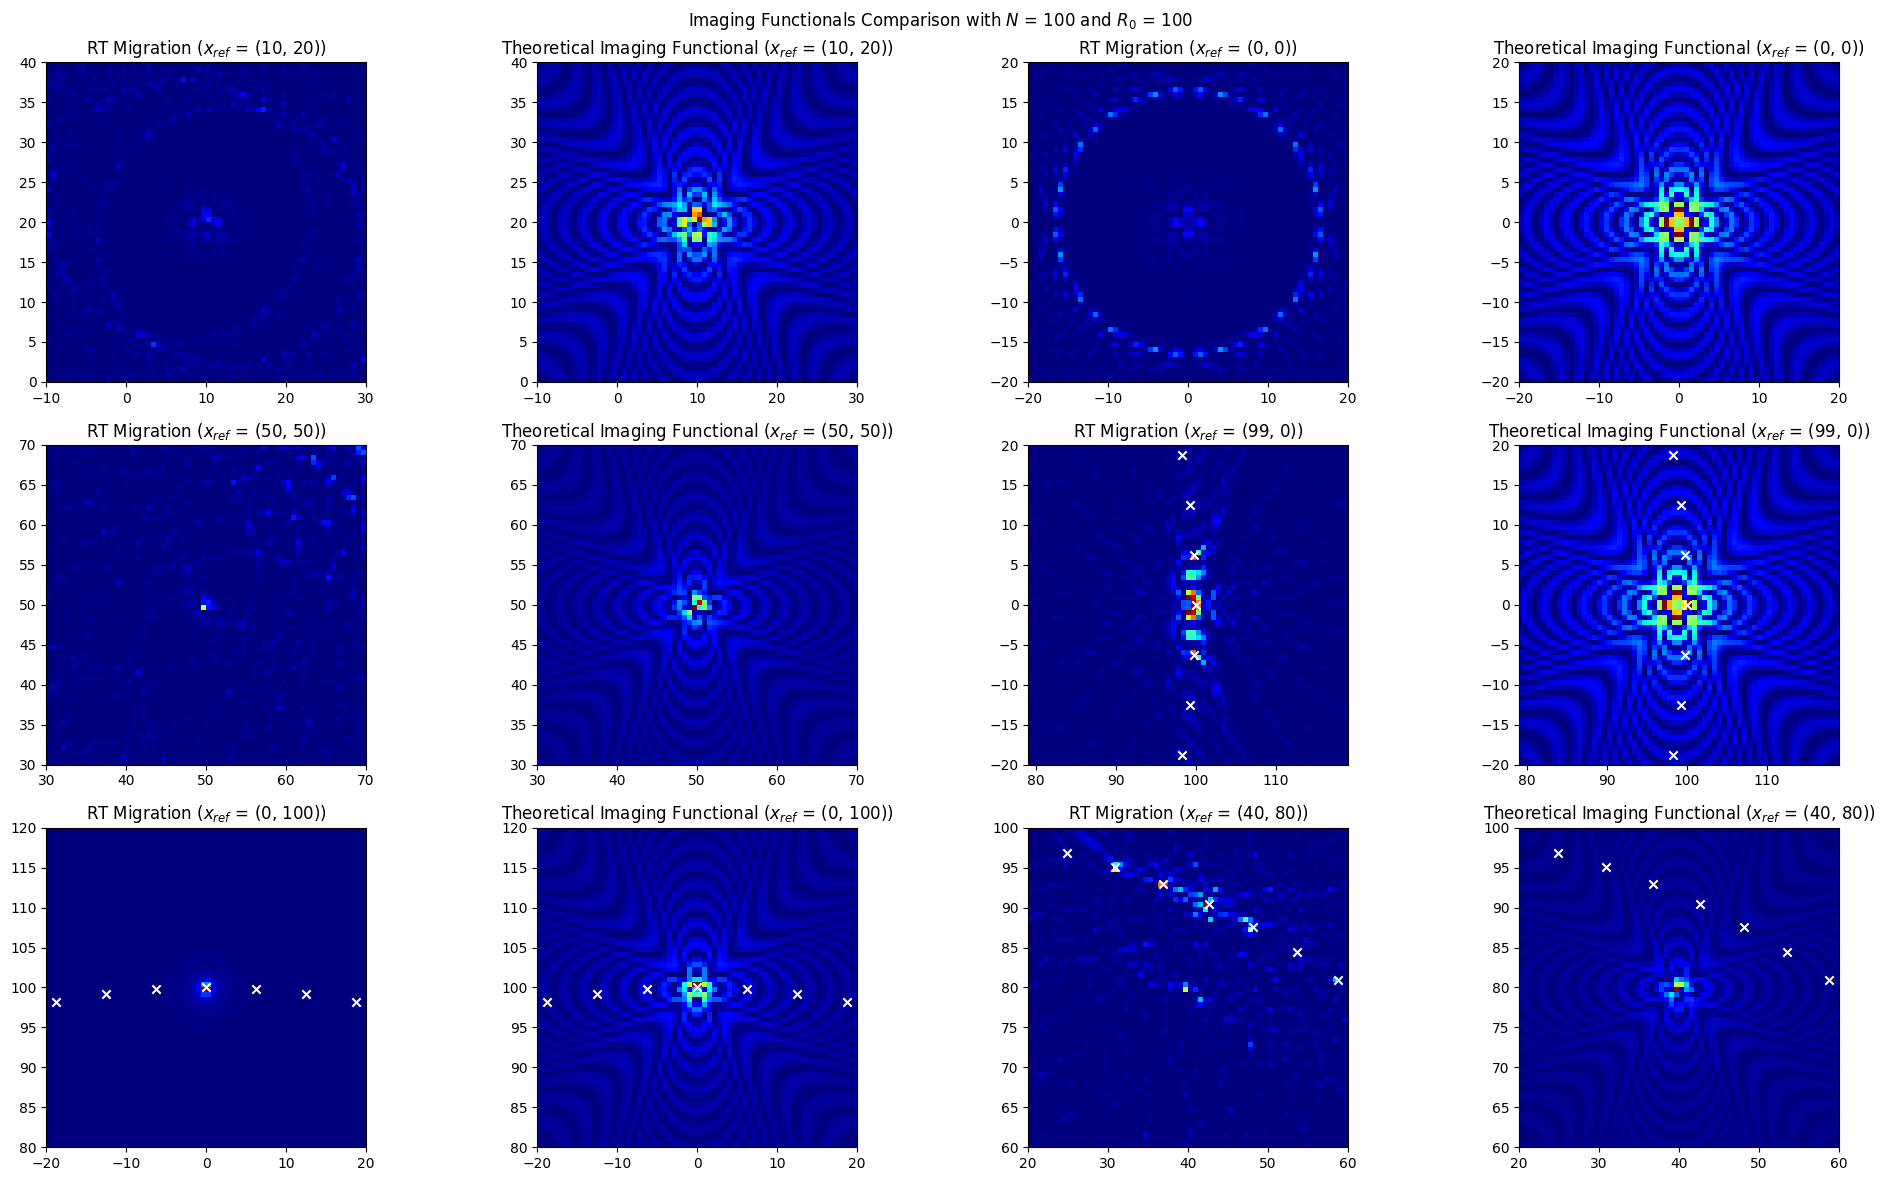

In [36]:
ref_positions = [(10, 20), (0, 0), (50, 50), (99, 0), (0, 100), (40, 80)]
num_rows = len(ref_positions) // 2
num_cols = 4  # 2 plots per position * 2 positions per row

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12))

for idx, x_ref in enumerate(ref_positions):
    # Update window for current reflector position
    x_zoom = (x_ref[0] - zoom_half_width, x_ref[0] + zoom_half_width)
    z_zoom = (x_ref[1] - zoom_half_width, x_ref[1] + zoom_half_width)

    # Generate data matrix using Born approximation
    dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
    v_t = GreenRT(dist_t_ref, w)
    U = -(w**2 / 16) * np.outer(v_t, v_t)

    # Imaging
    I_RT = np.zeros_like(X, dtype=float)

    for i in range(n):
        for j in range(n):
            X_ij = np.array([X[i, j], Z[i, j]])

            # Distances from transducers to current imaging point
            dists = np.linalg.norm(x_t - X_ij, axis=1)

            # Reverse-Time migration
            g_rt = GreenRT(dists, w)
            vec_rt = np.conj(g_rt)
            sum_RT = vec_rt @ U @ vec_rt.T
            I_RT[i, j] = np.abs(sum_RT) ** 2

    # Theoretical resolution
    dist_grid_ref = np.sqrt((X - x_ref[0]) ** 2 + (Z - x_ref[1]) ** 2)
    I_TH = j0(w * dist_grid_ref) ** 2

    # Normalize for better visualization
    I_RT /= I_RT.max()
    I_TH /= I_TH.max()

    # Calculate grid location
    row_idx = idx // 2
    col_start = (idx % 2) * 2  # Starts at 0 for even idx, 2 for odd idx
    ax_rt = axes[row_idx, col_start]
    ax_th = axes[row_idx, col_start + 1]

    ax_rt.set_title(f"RT Migration ($x_{{ref}}$ = {x_ref})")
    ax_rt.imshow(
        I_RT, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
    )
    ax_rt.scatter(x_t[:, 0], x_t[:, 1], color="white", marker="x", label="Transducers")
    ax_rt.set_xlim(x_zoom)
    ax_rt.set_ylim(z_zoom)

    ax_th.set_title(f"Theoretical Imaging Functional ($x_{{ref}}$ = {x_ref})")
    ax_th.imshow(
        I_TH, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
    )
    ax_th.scatter(x_t[:, 0], x_t[:, 1], color="white", marker="x", label="Transducers")
    ax_th.set_xlim(x_zoom)
    ax_th.set_ylim(z_zoom)

fig.suptitle(f"Imaging Functionals Comparison with $N$ = {N} and $R_0$ = {R0}")
plt.tight_layout()
plt.savefig("figures/Full_Aperture_Multiple_Reflectors.png", dpi=300)
plt.show()

#### Far-field approximation

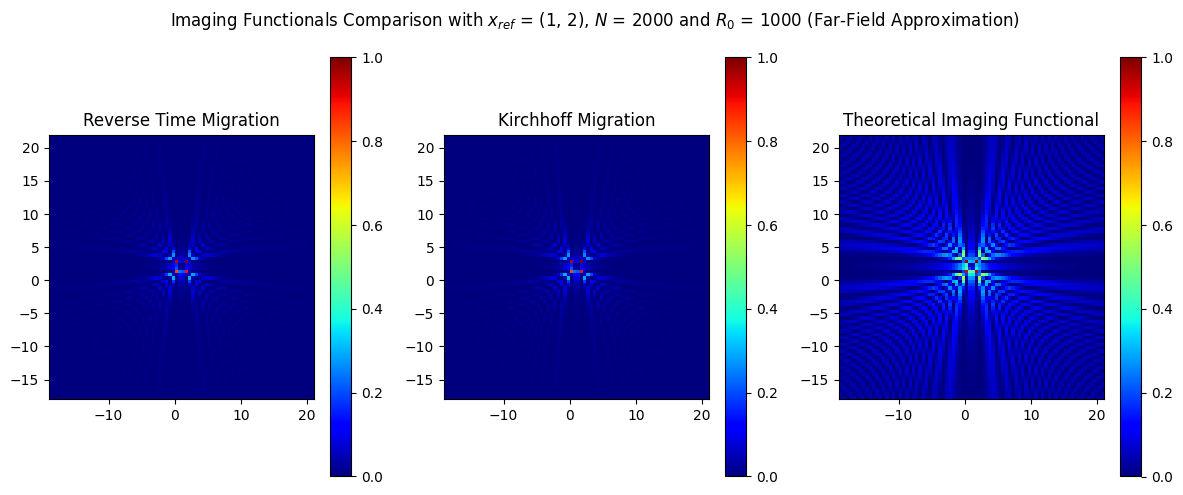

In [37]:
# Parameters
N = 2000  # Number of transducers
w = 2 * np.pi  # Frequency
R0 = 1000  # Array radius
x_ref = (1, 2)  # Point-like reflector position

theta_t = np.linspace(0, 2 * np.pi, N, endpoint=False)  # Angles for transducers
x_t = np.stack(
    (R0 * np.cos(theta_t), R0 * np.sin(theta_t)), axis=-1
)  # Transducer positions

# Grid parameters for imaging
n = 200
xlim = (-50, 50)
zlim = (-50, 50)
x = np.linspace(xlim[0], xlim[1], n)
z = np.linspace(zlim[0], zlim[1], n)
X, Z = np.meshgrid(x, z)

# Define zoom window size
zoom_half_width = 20

x_zoom = (x_ref[0] - zoom_half_width, x_ref[0] + zoom_half_width)
z_zoom = (x_ref[1] - zoom_half_width, x_ref[1] + zoom_half_width)

# Generate data matrix using Born approximation
dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
v_t = GreenRT(dist_t_ref, w)
U = -(w**2 / 16) * np.outer(v_t, v_t)

# Compute imaging functionals
I_RT = np.zeros_like(X, dtype=float)
I_KM = np.zeros_like(X, dtype=float)

for i in range(n):
    for j in range(n):
        X_ij = np.array([X[i, j], Z[i, j]])

        dists = np.linalg.norm(x_t - X_ij, axis=1)

        # Reverse-Time migration
        g_rt = GreenRT(dists, w)
        vec_rt = np.conj(g_rt)
        sum_RT = vec_rt @ U @ vec_rt.T
        I_RT[i, j] = np.abs(sum_RT) ** 2

        # Kirchhoff Migration
        vec_KM = GreenKM(dists, w)
        sum_KM = vec_KM @ U @ vec_KM.T
        I_KM[i, j] = np.abs(sum_KM) ** 2

# Theoretical resolution
dist_grid_ref = np.sqrt((X - x_ref[0]) ** 2 + (Z - x_ref[1]) ** 2)
I_TH = j0(w * dist_grid_ref) ** 2

# Normalize for better visualization
I_RT /= I_RT.max()
I_KM /= I_KM.max()
I_TH /= I_TH.max()

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

im0 = axes[0].imshow(
    I_RT, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[0].set_title("Reverse Time Migration")
axes[0].set_xlim(x_zoom)
axes[0].set_ylim(z_zoom)
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(
    I_KM, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[1].set_title("Kirchhoff Migration")
axes[1].set_xlim(x_zoom)
axes[1].set_ylim(z_zoom)
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(
    I_TH, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[2].set_title("Theoretical Imaging Functional")
axes[2].set_xlim(x_zoom)
axes[2].set_ylim(z_zoom)
plt.colorbar(im2, ax=axes[2])


fig.suptitle(
    f"Imaging Functionals Comparison with $x_{{ref}}$ = {x_ref}, $N$ = {N} and $R_0$ = {R0} (Far-Field Approximation)"
)
plt.tight_layout()
plt.savefig("figures/Full_Aperture_Far_Field.png", dpi=300)
plt.show()

<blockquote>

### Numerical implementation and results

The first figure presents the reverse-time (RT), Kirchhoff migration (KM), and theoretical focal spot profiles obtained for $\omega = 2\pi$, $R_0 = 100$, $N = 100$, and $x_{\mathrm{ref}} = (10,20)$. The RT and KM imaging functionals exhibit a very similar spatial distribution, with only minor discrepancies attributable to the approximation of the Green’s function used in the KM formulation. In contrast, the theoretical focal spot profile differs noticeably from both numerical imaging functionals. This discrepancy is expected, as the theoretical expression is derived under asymptotic assumptions, namely an infinite number of transducers and an array of infinite radius. These conditions are clearly not satisfied in this configuration. Nevertheless, in a very small neighborhood around the reflector location, all three profiles display qualitatively similar patterns, indicating that the theoretical profile may capture some essential features of the imaging functionals around the reflector.

We further investigate the influence of the reflector position by relocating it to several points within the array, including the center ($\bm{x}_{\text{ref}} = (0,0)$) and positions near the array boundary ($\bm{x}_{\text{ref}} = (0,100)$ and $(100,0)$). The resulting RT images reveal a clear dependence on the reflector location. In particular, when the reflector approaches the boundary of the array, the discrepancy between the RT image and the theoretical focal spot profile becomes more pronounced. This observation is consistent with the asymptotic derivation of the theoretical profile, which as we mentioned earlier, assumes the limit $R_0 \to \infty$. 

Finally, to better approximate the far-field regime, we increase the array radius to $R_0 = 1000$ and the number of transducers to $N = 2000$. Under these conditions, the RT and KM imaging functionals show a much closer agreement with the theoretical focal spot profile. In particular, close to the reflector, all three profiles exhibit similar patterns, indicating convergence toward the asymptotic theoretical prediction as the array parameters approach the far-field regime.

</blockquote>

---
## 3) Time-harmonic localization - partial aperture

We use the convention $x = (x, z)$.

Consider $N$ receivers $(x_r)_{r=1,\dots,N}$ on a regular linear array (along the $x$-direction) centered at $0$ with length $R_0$ (i.e. $x_r = (x_r, 0), x_r = - R_0/2 + R_0 (r - 1) / (N-1)$).

Generate the data set, i.e. the matrix of the time-harmonic amplitudes $\hat{u}_{rs}(\omega)$ recorded by the $r$-th receiver when the $s$-th source emits a time-harmonic signal with unit amplitude and frequency $\omega$. Use a Born approximation for the point-like reflector.

Plot the (two-dimensional) RT and KM imaging functional $\mathcal{I}_{RT}(x)$ and $\mathcal{I}_{KM}(x)$ using the data set. Plot also the MUSIC-type imaging functional $$\mathcal{I}_{MU}(x) = |\langle \hat{g}(\omega, x), v_1 \rangle|^2,$$ where $\hat{g}(\omega, x)$ is the vector of the Green's functions from the array to the search point $x$: $$\hat{g}(\omega, x) = (\hat{G}_0(\omega, x, x_r))_{r=1,\dots,N}$$ and $v_1$ is the first singular vector of the response matrix $\hat{u}$ (MUSIC means MUltiple SIgnal Classification).

Use $\omega = 2\pi$, $R_0 = 50$, $N = 100$, and $x_{ref} = (0, 100)$, and play with the numbers (Reduce $R_0$, move the reflector).

Look at the focal spot in the (cross-range) $x$-direction and compare with the theoretical function $\text{sinc}^2(\pi |x - x_{ref})|/r_c)$, with $r_c = \lambda |x_{ref}| / R_0$ and $\lambda = 2\pi / \omega$.

Look at the focal spot in the (range) $z$-direction and compare with the theoretical function $|\int_{0}^{1} \exp(-i \frac{\pi}{2} s^2 \frac{|z-z_{ref})}{r_l}) ds|^2$, with $r_l = 2 \lambda |x_{ref}|^2 / R_0^2$.

In [38]:
# Parameters
N = 100  # Number of transducers
w = 2 * np.pi  # Frequency
R0 = 50  # Array radius
x_ref = (0, 100)  # Point-like reflector position

x_coords = np.linspace(-R0 / 2, R0 / 2, N)  # Transducer x-coordinates
x_t = np.stack((x_coords, np.zeros(N)), axis=-1)  # Transducer positions

# Grid parameters for imaging
n = 400
xlim = (-125, 125)
zlim = (-125, 125)
x = np.linspace(xlim[0], xlim[1], n)
z = np.linspace(zlim[0], zlim[1], n)
X, Z = np.meshgrid(x, z)

# Define zoom window size
zoom_half_width = 20

x_zoom = (x_ref[0] - zoom_half_width, x_ref[0] + zoom_half_width)
z_zoom = (x_ref[1] - zoom_half_width, x_ref[1] + zoom_half_width)

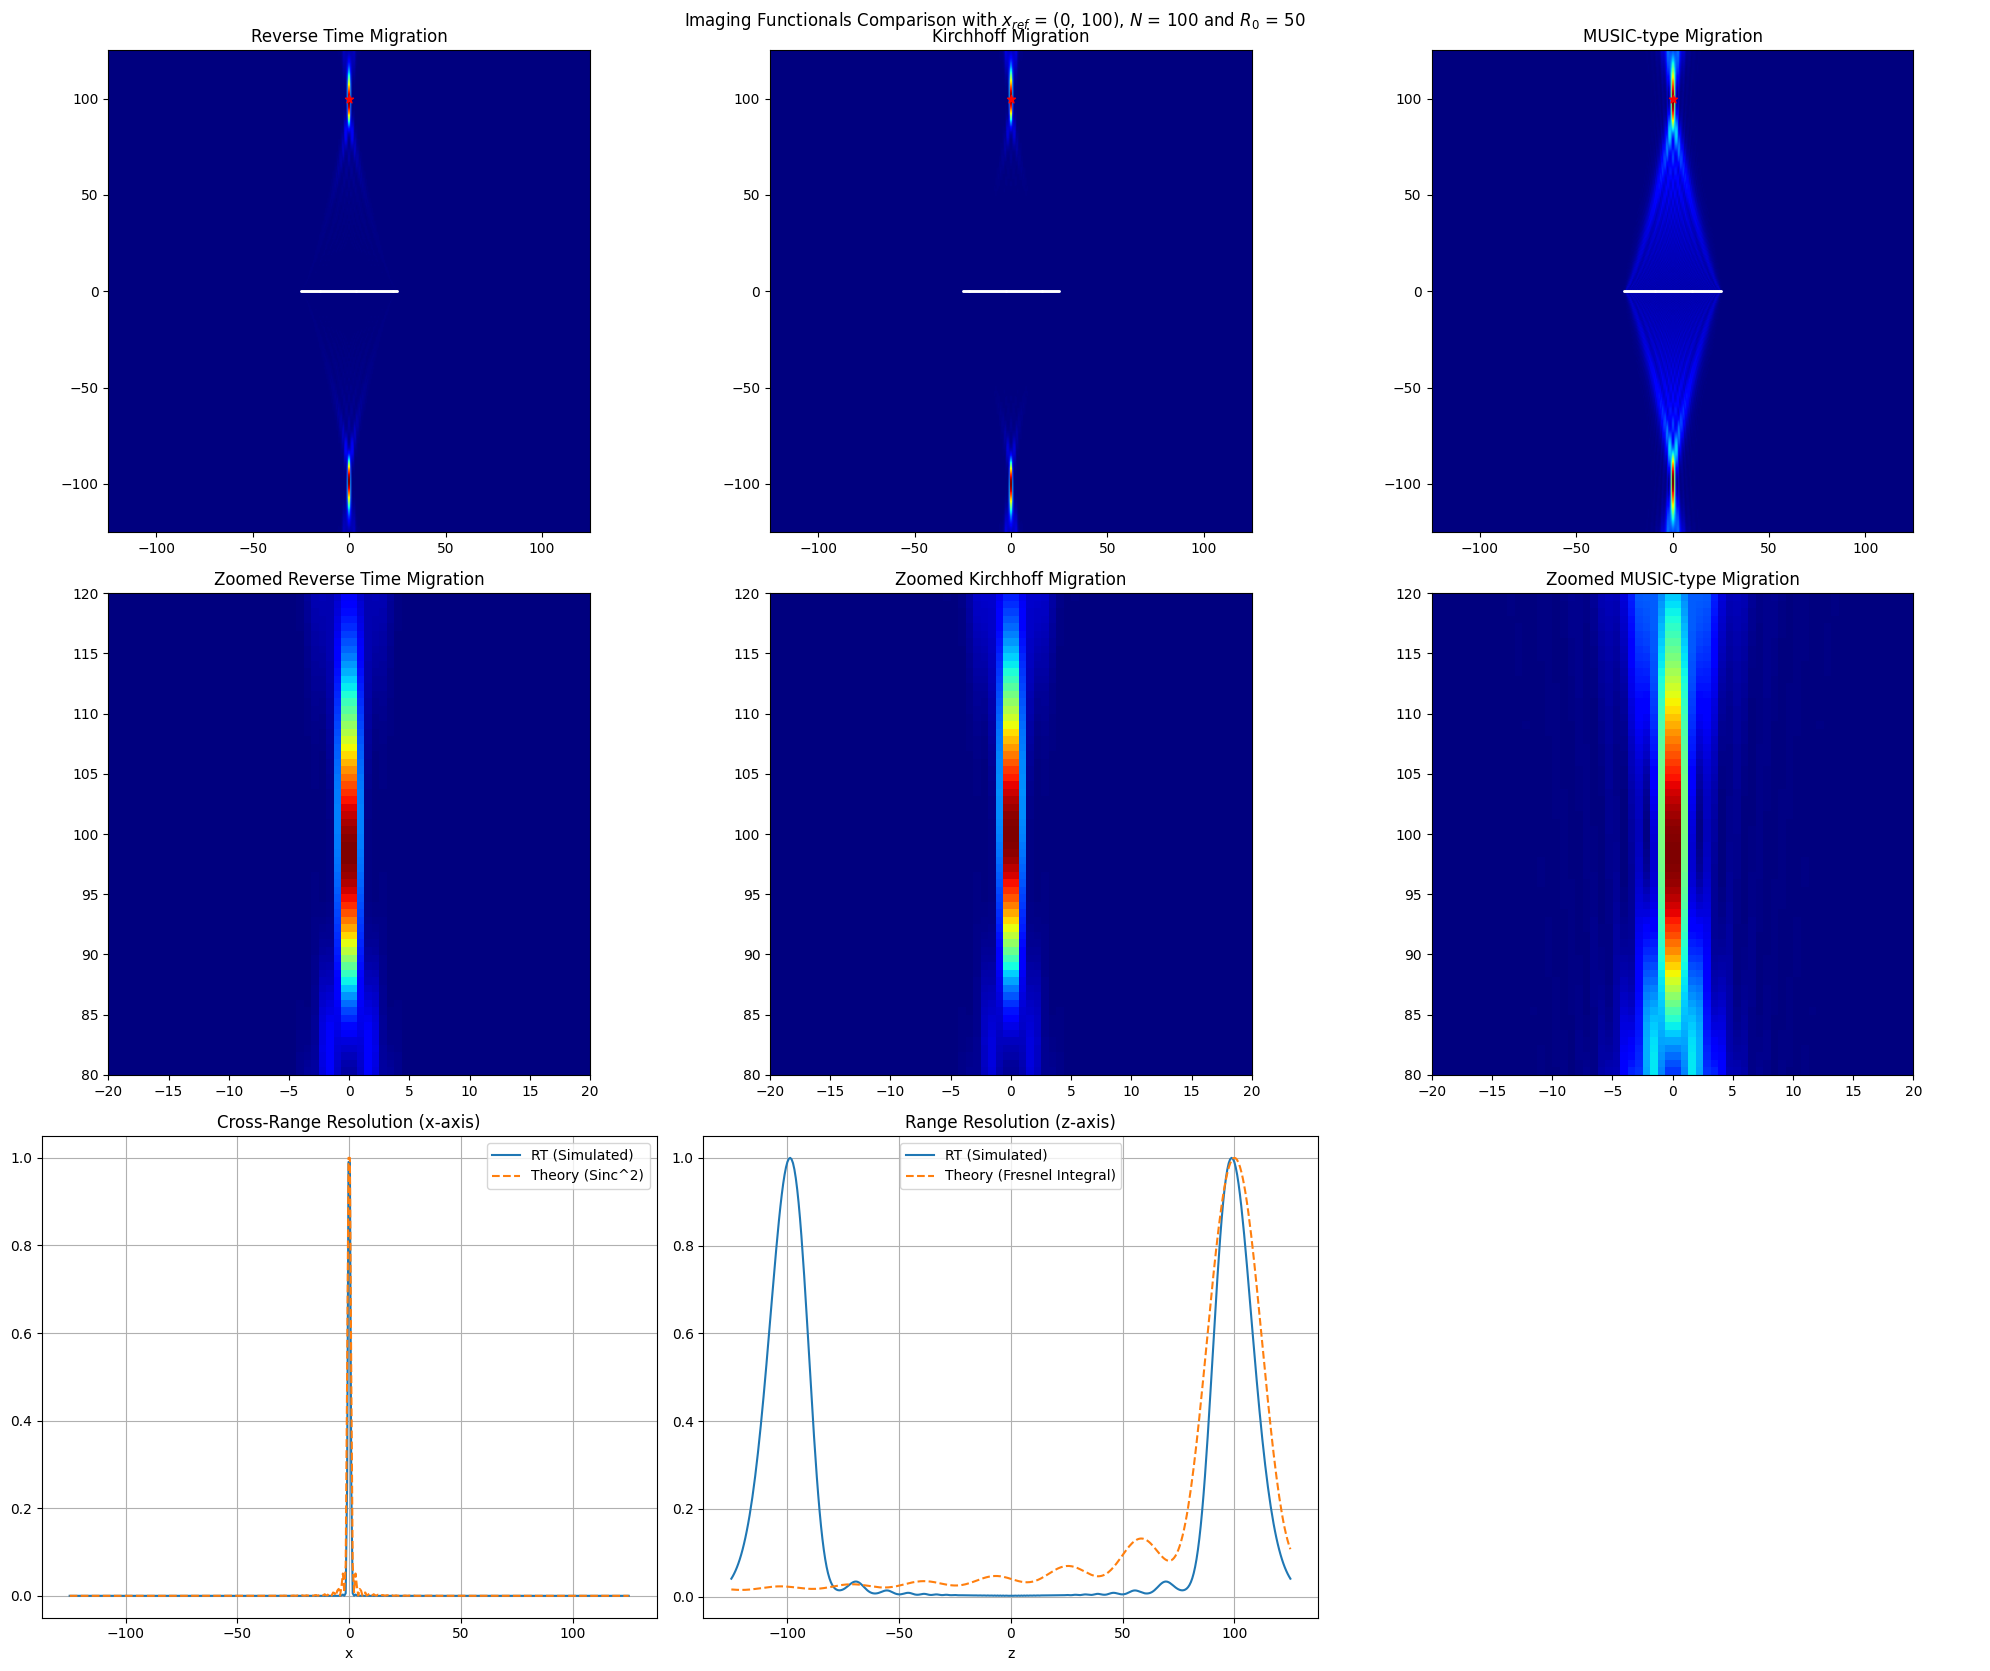

In [39]:
# Generate data matrix using Born approximation
dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
v_t = GreenRT(dist_t_ref, w)
U = -(w**2 / 16) * np.outer(v_t, v_t)

# Compute imaging functionals
I_RT = np.zeros_like(X, dtype=float)
I_KM = np.zeros_like(X, dtype=float)
I_MU = np.zeros_like(X, dtype=float)

# First singular vector for MUSIC-type functional
u_svd, s_svd, vh_svd = np.linalg.svd(U)
u1 = u_svd[:, 0]

for i in range(n):
    for j in range(n):
        X_ij = np.array([X[i, j], Z[i, j]])
        dists = np.linalg.norm(x_t - X_ij, axis=1)

        # Reverse-Time migration
        g_rt = GreenRT(dists, w)
        vec_rt = np.conj(g_rt)
        sum_RT = vec_rt @ U @ vec_rt.T
        I_RT[i, j] = np.abs(sum_RT) ** 2

        # Kirchhoff Migration
        vec_KM = GreenKM(dists, w)
        sum_KM = vec_KM @ U @ vec_KM.T
        I_KM[i, j] = np.abs(sum_KM) ** 2

        # MUSIC
        g_music = GreenRT(dists, w)
        proj = g_music @ u1.conj()
        I_MU[i, j] = np.abs(proj) ** 2

# Normalize Images
I_RT /= I_RT.max()
I_KM /= I_KM.max()
I_MU /= I_MU.max()

# Theoretical resolution
lam = 2 * np.pi / w
norm_x_ref = np.linalg.norm(x_ref)
r_c = (lam * norm_x_ref) / R0
r_l = (2 * lam * norm_x_ref**2) / (R0**2)

# Cross-Range Slice
z_idx = np.argmin(np.abs(z - x_ref[1]))
x_slice_vals = X[z_idx, :]
rt_slice_x = I_RT[z_idx, :]
th_slice_x = np.sinc((x_slice_vals - x_ref[0]) / r_c) ** 2
th_slice_x /= th_slice_x.max()

# Range Slice
x_idx = np.argmin(np.abs(x - x_ref[0]))
z_slice_vals = Z[:, x_idx]
rt_slice_z = I_RT[:, x_idx]

# Theoretical Integral for Range
th_slice_z = []
s_dummy = np.linspace(0, 1, 1000)

for z_val in z_slice_vals:
    phase_factor = (np.pi / 2) * (np.abs(z_val - x_ref[1]) / r_l)
    integrand = np.exp(-1j * phase_factor * (s_dummy**2))
    val = np.abs(np.trapezoid(integrand, s_dummy)) ** 2
    th_slice_z.append(val)

th_slice_z = np.array(th_slice_z)
th_slice_z /= th_slice_z.max()

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(20, 17))

axes[0, 0].imshow(
    I_RT, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[0, 0].set_title("Reverse Time Migration")
axes[0, 0].scatter(*x_ref, color="red", marker="*")
axes[0, 0].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)

axes[0, 1].imshow(
    I_KM, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[0, 1].set_title("Kirchhoff Migration")
axes[0, 1].scatter(*x_ref, color="red", marker="*")
axes[0, 1].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)

axes[0, 2].imshow(
    I_MU, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[0, 2].set_title("MUSIC-type Migration")
axes[0, 2].scatter(*x_ref, color="red", marker="*")
axes[0, 2].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)

axes[1, 0].imshow(
    I_RT, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[1, 0].set_title("Zoomed Reverse Time Migration")
axes[1, 0].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
axes[1, 0].set_xlim(x_zoom)
axes[1, 0].set_ylim(z_zoom)

axes[1, 1].imshow(
    I_KM, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[1, 1].set_title("Zoomed Kirchhoff Migration")
axes[1, 1].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
axes[1, 1].set_xlim(x_zoom)
axes[1, 1].set_ylim(z_zoom)

axes[1, 2].imshow(
    I_MU, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[1, 2].set_title("Zoomed MUSIC-type Migration")
axes[1, 2].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
axes[1, 2].set_xlim(x_zoom)
axes[1, 2].set_ylim(z_zoom)

# Cross-Range
axes[2, 0].plot(x_slice_vals, rt_slice_x, label="RT (Simulated)")
axes[2, 0].plot(x_slice_vals, th_slice_x, "--", label="Theory (Sinc^2)")
axes[2, 0].set_title("Cross-Range Resolution (x-axis)")
axes[2, 0].set_xlabel("x")
axes[2, 0].legend()
axes[2, 0].grid(True)

# Range
axes[2, 1].plot(z_slice_vals, rt_slice_z, label="RT (Simulated)")
axes[2, 1].plot(z_slice_vals, th_slice_z, "--", label="Theory (Fresnel Integral)")
axes[2, 1].set_title("Range Resolution (z-axis)")
axes[2, 1].set_xlabel("z")
axes[2, 1].legend()
axes[2, 1].grid(True)

axes[2, 2].axis("off")

fig.suptitle(
    f"Imaging Functionals Comparison with $x_{{ref}}$ = {x_ref}, $N$ = {N} and $R_0$ = {R0}"
)
plt.tight_layout()
plt.savefig("figures/Partial_Aperture.png", dpi=300)
plt.show()

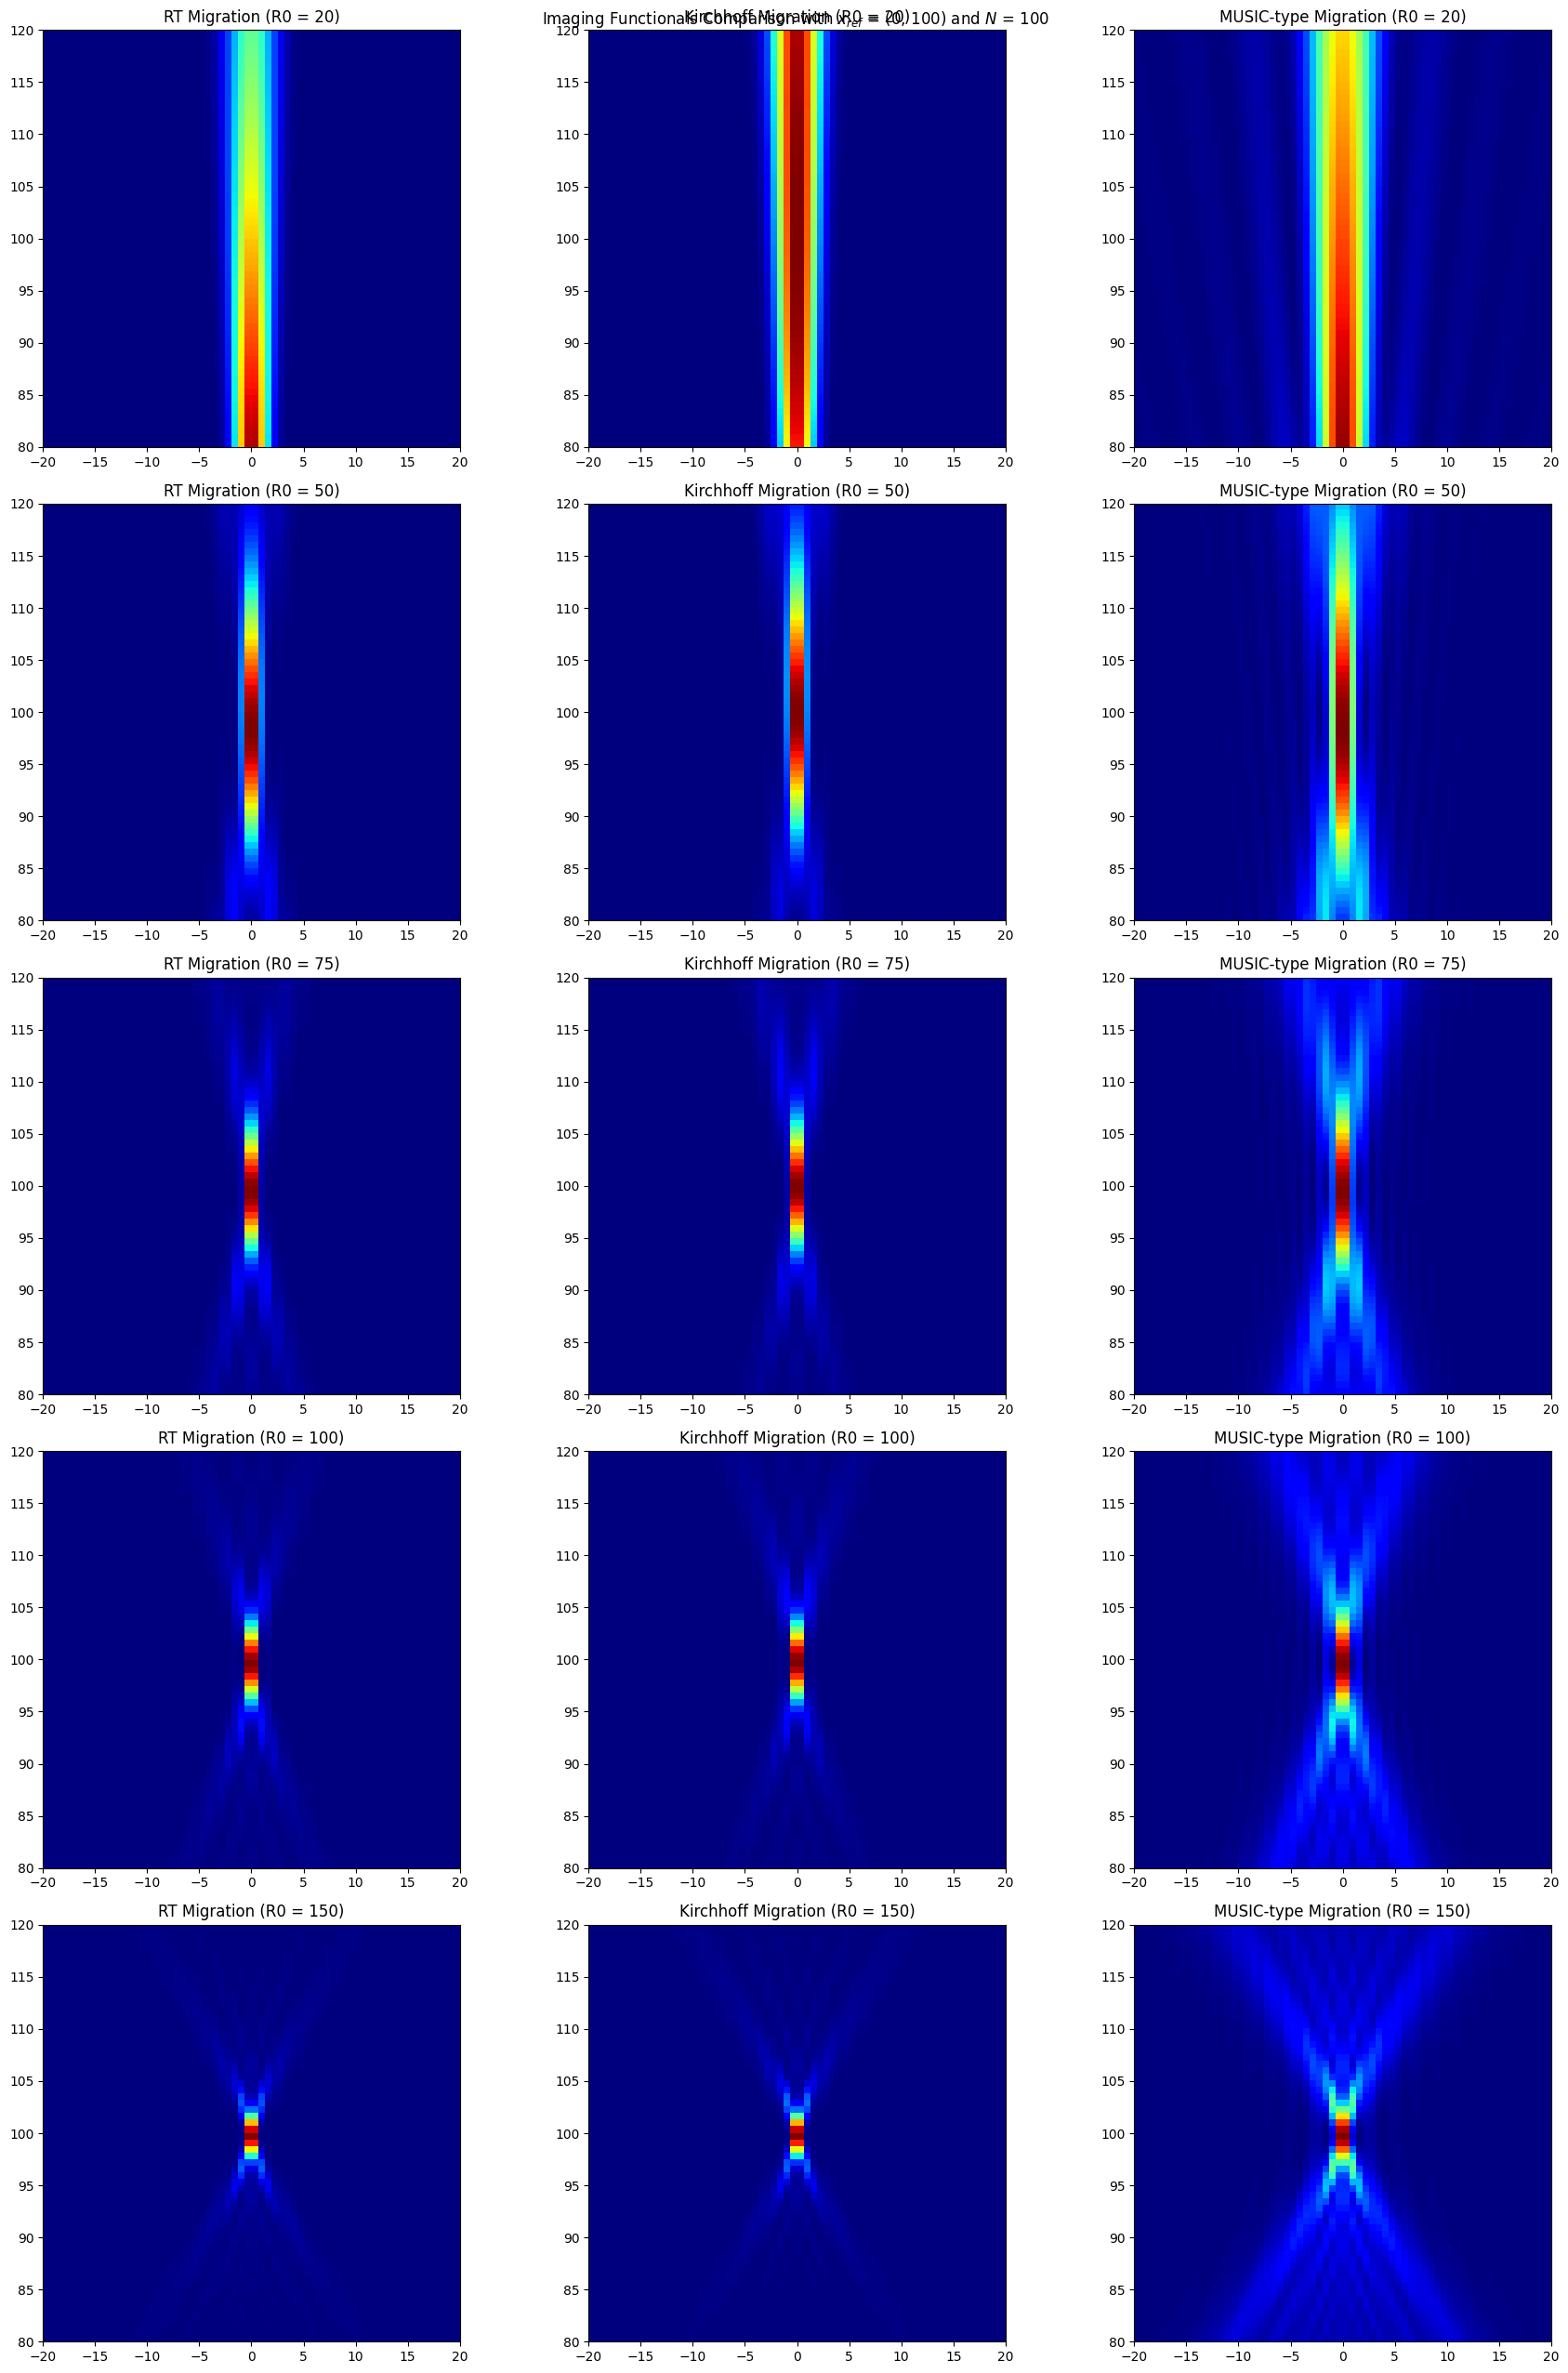

In [40]:
# Values of R0 to test
R0_values = [20, 50, 75, 100, 150]

# Create figure: len(R0_values) rows × 3 columns
fig, axes = plt.subplots(len(R0_values), 3, figsize=(18, 5 * len(R0_values) + 1))

for idx, R0 in enumerate(R0_values):
    # Transducer positions
    x_coords = np.linspace(-R0 / 2, R0 / 2, N)
    x_t = np.stack((x_coords, np.zeros(N)), axis=-1)

    # Generate data matrix using Born approximation
    dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
    v_t = GreenRT(dist_t_ref, w)
    U = -(w**2 / 16) * np.outer(v_t, v_t)

    # Compute imaging functionals
    I_RT = np.zeros_like(X, dtype=float)
    I_KM = np.zeros_like(X, dtype=float)
    I_MU = np.zeros_like(X, dtype=float)

    # First singular vector for MUSIC-type functional
    u_svd, s_svd, vh_svd = np.linalg.svd(U)
    u1 = u_svd[:, 0]

    for i in range(n):
        for j in range(n):
            X_ij = np.array([X[i, j], Z[i, j]])
            dists = np.linalg.norm(x_t - X_ij, axis=1)

            # Reverse-Time migration
            g_rt = GreenRT(dists, w)
            vec_rt = np.conj(g_rt)
            sum_RT = vec_rt @ U @ vec_rt.T
            I_RT[i, j] = np.abs(sum_RT) ** 2

            # Kirchhoff Migration
            vec_KM = GreenKM(dists, w)
            sum_KM = vec_KM @ U @ vec_KM.T
            I_KM[i, j] = np.abs(sum_KM) ** 2

            # MUSIC
            g_music = GreenRT(dists, w)
            proj = g_music @ u1.conj()
            I_MU[i, j] = np.abs(proj) ** 2

    # Normalize Images
    I_RT /= I_RT.max()
    I_KM /= I_KM.max()
    I_MU /= I_MU.max()

    # Plot only zoomed versions
    axes[idx, 0].imshow(
        I_RT, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
    )
    axes[idx, 0].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
    axes[idx, 0].set_xlim(x_zoom)
    axes[idx, 0].set_ylim(z_zoom)
    axes[idx, 0].set_title(f"RT Migration (R0 = {R0})")

    axes[idx, 1].imshow(
        I_KM, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
    )
    axes[idx, 1].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
    axes[idx, 1].set_xlim(x_zoom)
    axes[idx, 1].set_ylim(z_zoom)
    axes[idx, 1].set_title(f"Kirchhoff Migration (R0 = {R0})")

    axes[idx, 2].imshow(
        I_MU, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
    )
    axes[idx, 2].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
    axes[idx, 2].set_xlim(x_zoom)
    axes[idx, 2].set_ylim(z_zoom)
    axes[idx, 2].set_title(f"MUSIC-type Migration (R0 = {R0})")

fig.suptitle(f"Imaging Functionals Comparison with $x_{{ref}}$ = {x_ref} and $N$ = {N}")
plt.tight_layout()
plt.savefig("figures/Partial_Aperture_Multiple_R0.png", dpi=300)
plt.show()

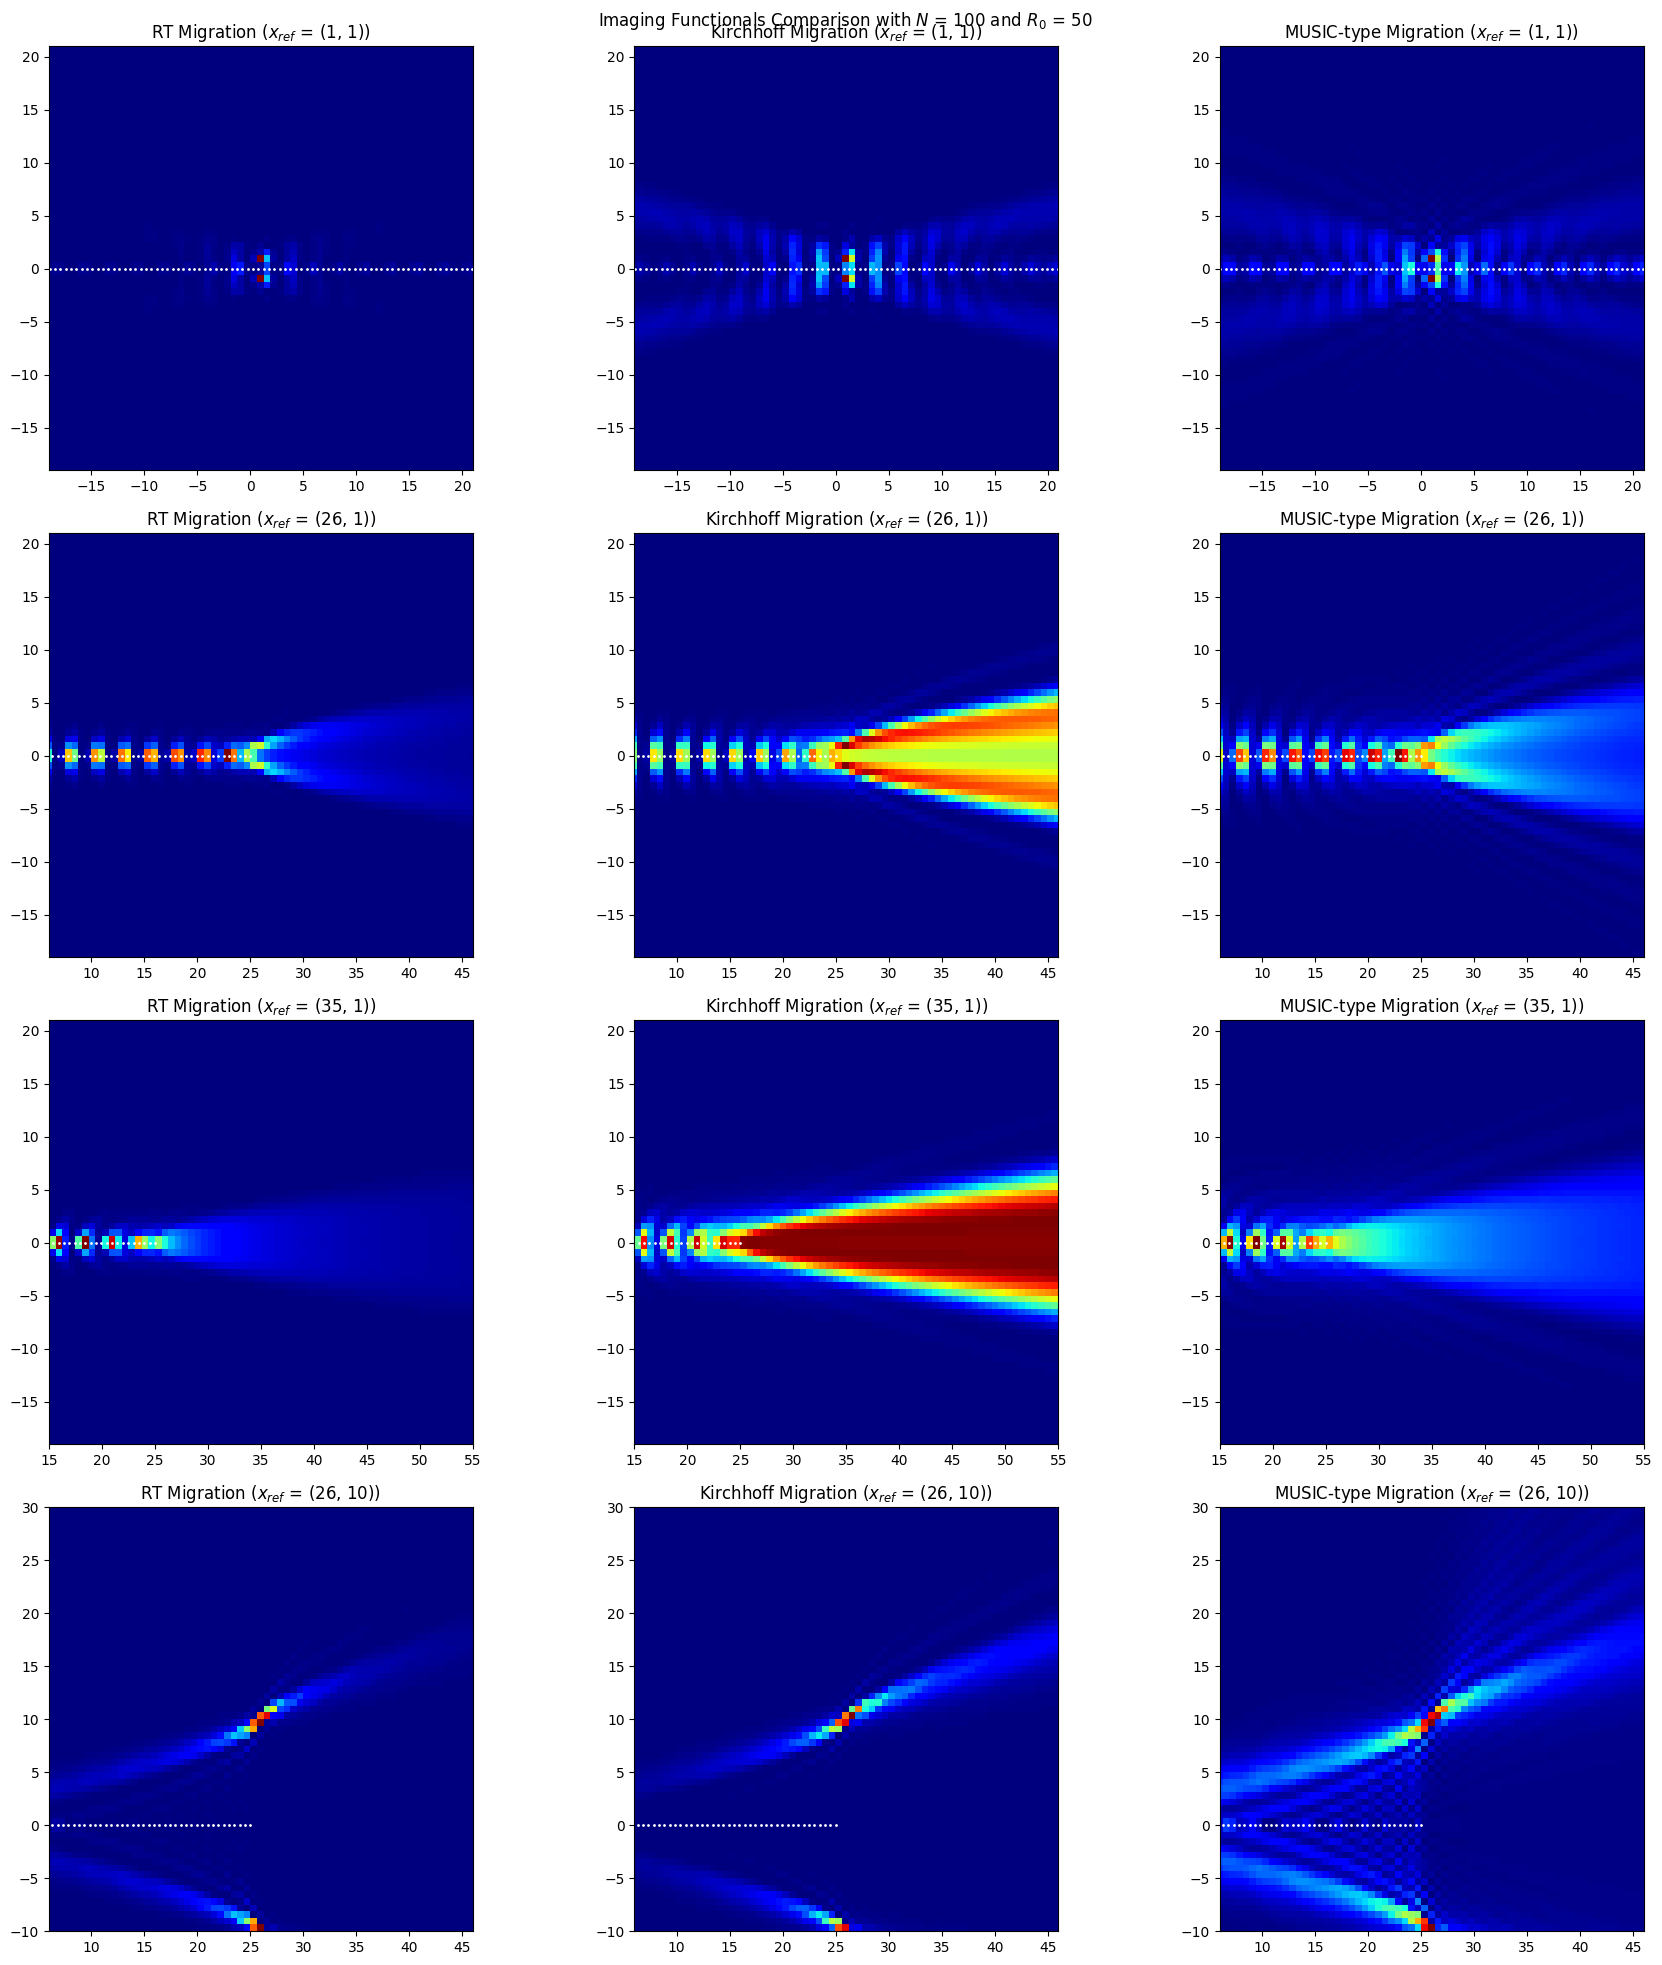

In [41]:
# Parameters
N = 100  # Number of transducers
w = 2 * np.pi  # Frequency
R0 = 50  # Array radius

# Transducer positions (fixed now)
x_coords = np.linspace(-R0 / 2, R0 / 2, N)
x_t = np.stack((x_coords, np.zeros(N)), axis=-1)

# Grid parameters for imaging
n = 400
xlim = (-125, 125)
zlim = (-125, 125)
x = np.linspace(xlim[0], xlim[1], n)
z = np.linspace(zlim[0], zlim[1], n)
X, Z = np.meshgrid(x, z)

# Reflector positions
ref_positions = [(1, 1), (26, 1), (35, 1), (26, 10)]

# Zoom window size
zoom_half_width = 20

# Create figure: len(ref_positions) rows x 3 columns
fig, axes = plt.subplots(len(ref_positions), 3, figsize=(18, 5 * len(ref_positions)))

for idx, x_ref in enumerate(ref_positions):
    # Define zoom window centered at current reflector
    x_zoom = (x_ref[0] - zoom_half_width, x_ref[0] + zoom_half_width)
    z_zoom = (x_ref[1] - zoom_half_width, x_ref[1] + zoom_half_width)

    # Generate data matrix using Born approximation
    dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
    v_t = GreenRT(dist_t_ref, w)
    U = -(w**2 / 16) * np.outer(v_t, v_t)

    # Compute imaging functionals
    I_RT = np.zeros_like(X, dtype=float)
    I_KM = np.zeros_like(X, dtype=float)
    I_MU = np.zeros_like(X, dtype=float)

    # First singular vector for MUSIC-type functional
    u_svd, s_svd, vh_svd = np.linalg.svd(U)
    u1 = u_svd[:, 0]

    for i in range(n):
        for j in range(n):
            X_ij = np.array([X[i, j], Z[i, j]])
            dists = np.linalg.norm(x_t - X_ij, axis=1)

            # Reverse-Time migration
            g_rt = GreenRT(dists, w)
            vec_rt = np.conj(g_rt)
            sum_RT = vec_rt @ U @ vec_rt.T
            I_RT[i, j] = np.abs(sum_RT) ** 2

            # Kirchhoff Migration
            vec_KM = GreenKM(dists, w)
            sum_KM = vec_KM @ U @ vec_KM.T
            I_KM[i, j] = np.abs(sum_KM) ** 2

            # MUSIC
            g_music = GreenRT(dists, w)
            proj = g_music @ u1.conj()
            I_MU[i, j] = np.abs(proj) ** 2

    # Normalize
    I_RT /= I_RT.max()
    I_KM /= I_KM.max()
    I_MU /= I_MU.max()

    # Plot only zoomed versions
    axes[idx, 0].imshow(
        I_RT, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
    )
    axes[idx, 0].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
    axes[idx, 0].set_xlim(x_zoom)
    axes[idx, 0].set_ylim(z_zoom)
    axes[idx, 0].set_title(f"RT Migration ($x_{{ref}}$ = {x_ref})")

    axes[idx, 1].imshow(
        I_KM, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
    )
    axes[idx, 1].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
    axes[idx, 1].set_xlim(x_zoom)
    axes[idx, 1].set_ylim(z_zoom)
    axes[idx, 1].set_title(f"Kirchhoff Migration ($x_{{ref}}$ = {x_ref})")

    axes[idx, 2].imshow(
        I_MU, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
    )
    axes[idx, 2].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
    axes[idx, 2].set_xlim(x_zoom)
    axes[idx, 2].set_ylim(z_zoom)
    axes[idx, 2].set_title(f"MUSIC-type Migration ($x_{{ref}}$ = {x_ref})")

fig.suptitle(f"Imaging Functionals Comparison with $N$ = {N} and $R_0$ = {R0}")
plt.tight_layout()
plt.savefig("figures/Partial_Aperture_Multiple_Reflectors.png", dpi=300)
plt.show()


<blockquote>

### Numerical implementation and results

We consider a linear array of $N$ transducers distributed along the $x$-axis, centered at the origin, with total length $R_0$. Figure 1 displays the reverse-time (RT), Kirchhoff migration (KM), and MUSIC imaging functionals computed for $\omega = 2\pi$, $R_0 = 100$, $N = 100$, and $\bm{x}_{\mathrm{ref}} = (10,20)$. 

All functionals exhibit a similar spatial distribution, with the RT and KM images closely resembling each other, while the MUSIC image shows an additionnal pattern in the form of an enveloppe starting from the transducer array and extending towards the reflector. This can be attributed to the fact that the MUSIC algorithm relies on the signal subspace spanned by the singular vectors of the data matrix, which can capture additional features of the wave field beyond the direct path from the array to the reflector.

The two subsequent plots show the focal spot profiles along the $x$ and $z$-directions, together with their theoretical counterparts. Along the $x$-direction, the RT profile reproduces the main peak at the reflector position and secondary lobes predicted by theory. However, additional lobes are also visible away from the main peak. These additional peaks can be attributed to finite-aperture effects and to the discrete sampling of the array. Along the $z$-direction, the RT and theoretical profiles again share the same primary maximum at the reflector location. Nevertheless, the RT profile exhibits a second peak at the symmetric position with respect to the origin. This symmetry-induced artifact stems from the geometry of the array. Since all transducers lie on the $x$-axis, the imaging functional cannot discriminate between reflectors located at $z$ and $-z$ using travel-time information alone. Consequently, a mirror image of the reflector appears in the reconstructed profile.


In the second figure, we investigate the influence of the array length $R_0$ and the reflector position $\bm{x}_{\text{ref}}$ on the functionals. Increasing $R_0$ alone does not fundamentally alter the overall structure of the images, but it enhances the sharpness and amplitude of the observed patterns. This improvement is consistent with the fact that a larger aperture provides more comprehensive sampling of the wave field, thereby improving resolution. The effect is particularly noticeable for the RT functional, which directly incorporates the Green’s function and therefore benefits from increased aperture.

In contrast, varying the reflector position has a substantial impact on the reconstructed images. As the reflector approaches the array, the peaks in all three imaging functionals become more pronounced and closely resemble each other. This behavior can be explained by the growing dominance of the reflector contribution within the signal subspace used by the MUSIC algorithm when the reflector is located closer to the sensors. The effect is especially pronounced for the KM functional, which relies on travel-time information that becomes more accurate as the reflector approaches the array.

Overall, these results demonstrate the strong sensitivity of RT, KM, and MUSIC imaging functionals to both the array geometry and the reflector position, emphasizing the need to account for these parameters when interpreting reconstructed images.

</blockquote>

---
## 4) Time-dependent localization - partial aperture

Consider $N$ receivers on a linear array (along the $x$-direction) centered at $0$ with length $R_0$.

We now assume that the sources emit a broadband signal with $\hat{f}(\omega) = 1_{[\omega_0 - B, \omega_0 + B]}(\omega)$.

Generate the data set, i.e. the matrices of the time-harmonic amplitudes $\hat{d}_{rs}(\omega)$ recorded by the $r$-th receiver when the $s$-th source emits a time-harmonic signal with unit amplitude and frequency $\omega$, for $\omega$ sampled in $[\omega_0 - B, \omega_0 + B]$.

Plot the (two-dimensional) RT and KM imaging functional $\mathcal{I}_{RT}(x)$ and $\mathcal{I}_{KM}(x)$ using the data set.

Use $\omega_0 = 2\pi$, $B = 0.05\omega_0$, $R_0 = 20$, $N = 40$, and $x_{ref} = (0, 100)$, and play with the numbers (Reduce the bandwidth $B$ for instance).

Look at the focal spot in the (cross-range) $x$-direction and compare with the theoretical function $\text{sinc}^2(\pi |x - x_{ref})|/r_c)$, with $r_c = \lambda_0 |x_{ref}| / R_0$ and $\lambda_0 = 2\pi / \omega_0$.

Look at the focal spot in the (range) $z$-direction and compare with the theoretical function $|\operatorname{sinc}(2B |z-z_{ref}|)|$.

In [42]:
# Parameters
N = 40  # Number of receivers
w0 = 2 * np.pi  # Center frequency
B = 0.05 * w0  # Bandwidth
Nw = 41  # Number of frequencies samples in the band
ws = np.linspace(w0 - B, w0 + B, Nw)  # Frequency range

R0 = 20  # Array length
x_ref = (0, 100)  # Point-like reflector position

# Transducer positions
x_coords = np.linspace(-R0 / 2, R0 / 2, N)
x_t = np.stack((x_coords, np.zeros(N)), axis=-1)

# Grid parameters for imaging
n = 400
xlim = (-150, 150)
zlim = (-150, 150)
x = np.linspace(xlim[0], xlim[1], n)
z = np.linspace(zlim[0], zlim[1], n)
X, Z = np.meshgrid(x, z)

# Define zoom window size
zoom_half_width = 20

x_zoom = (x_ref[0] - zoom_half_width, x_ref[0] + zoom_half_width)
z_zoom = (x_ref[1] - zoom_half_width, x_ref[1] + zoom_half_width)

# Theoretical Parameters
lambda0 = 2 * np.pi / w0
r_c = (lambda0 * x_ref[1]) / R0  # Cross-range resolution scale

In [43]:
Image_RT = np.zeros_like(X, dtype=complex)
Image_KM = np.zeros_like(X, dtype=complex)

# Distances from transducers to imaging grid
grid_points = np.stack((X, Z), axis=-1)
dists_grid = np.linalg.norm(grid_points[:, :, None, :] - x_t[None, None, :, :], axis=3)

for omega in ws:
    # Data Matrix (Born Approximation)
    dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
    v_t = GreenRT(dist_t_ref, omega)
    U = -(omega**2 / 16) * np.outer(v_t, v_t)

    # Reverse-Time Migration
    g_rt = GreenRT(dists_grid, omega)
    vec_rt = np.conj(g_rt)
    temp_rt = vec_rt @ U
    step_rt = np.sum(vec_rt * temp_rt, axis=2)
    Image_RT += step_rt

    # Kirchhoff Migration
    g_km = GreenKM(dists_grid, omega)
    vec_km = np.conj(g_km)
    temp_km = vec_km @ U
    step_km = np.sum(vec_km * temp_km, axis=2)
    Image_KM += step_km

# Intensity
I_RT = np.abs(Image_RT) ** 2
I_KM = np.abs(Image_KM) ** 2

# Normalize
I_RT /= I_RT.max()
I_KM /= I_KM.max()

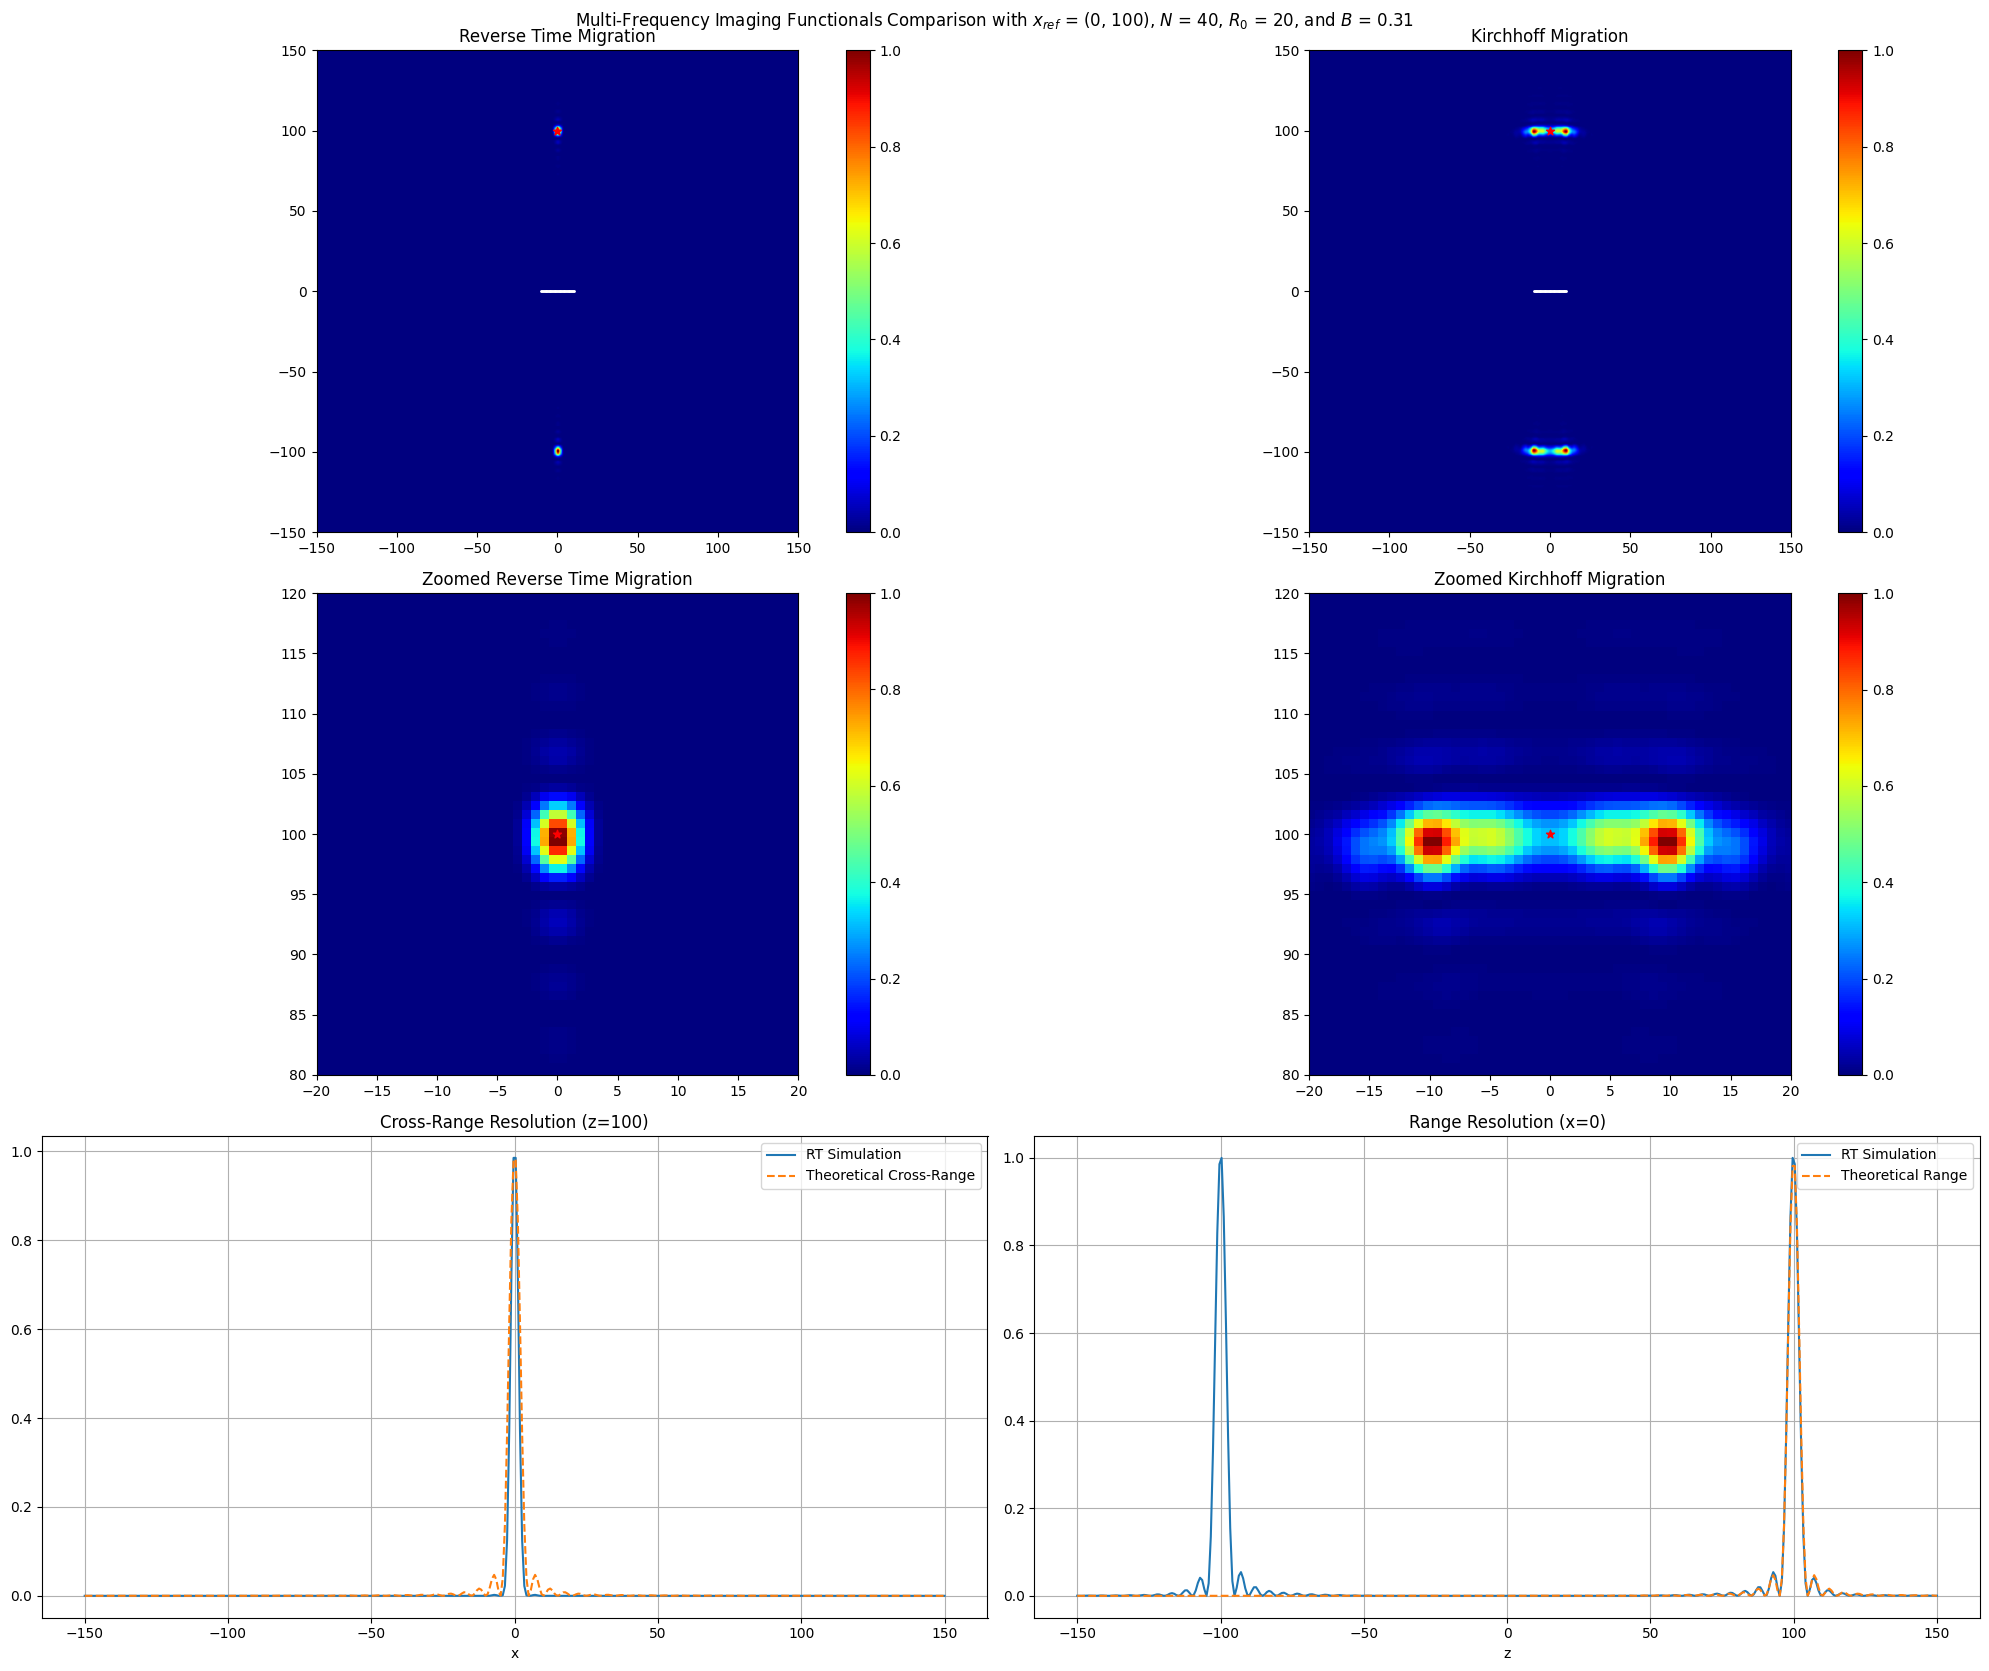

In [44]:
# Theoretical cross-range resolution
z_idx = np.argmin(np.abs(z - x_ref[1]))
rt_slice_x = I_RT[z_idx, :]
th_slice_x = np.sinc((x - x_ref[0]) / r_c) ** 2

# Theoretical range resolution
x_idx = np.argmin(np.abs(x - x_ref[0]))
rt_slice_z = I_RT[:, x_idx]
dist_z = np.abs(z - x_ref[1])
th_slice_z = np.abs(np.sinc((2 * B * dist_z) / np.pi)) ** 2

# Plot Results
fig, axes = plt.subplots(3, 2, figsize=(20, 17))

# Reverse-Time Migration Image
im1 = axes[0, 0].imshow(I_RT, extent=(*xlim, *zlim), origin="lower", cmap="jet")
axes[0, 0].set_title("Reverse Time Migration")
axes[0, 0].scatter(*x_ref, color="red", marker="*", label="Reflector")
axes[0, 0].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1, label="Transducers")
axes[0, 0].set_aspect("equal")
plt.colorbar(im1, ax=axes[0, 0])

# Kirchhoff Migration Image
im2 = axes[0, 1].imshow(I_KM, extent=(*xlim, *zlim), origin="lower", cmap="jet")
axes[0, 1].set_title("Kirchhoff Migration")
axes[0, 1].scatter(*x_ref, color="red", marker="*", label="Reflector")
axes[0, 1].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1, label="Transducers")
axes[0, 1].set_aspect("equal")
plt.colorbar(im2, ax=axes[0, 1])

# Zoomed Reverse-Time Migration Image
im3 = axes[1, 0].imshow(I_RT, extent=(*xlim, *zlim), origin="lower", cmap="jet")
axes[1, 0].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1, label="Transducers")
axes[1, 0].scatter(*x_ref, color="red", marker="*", label="Reflector")
axes[1, 0].set_title("Zoomed Reverse Time Migration")
axes[1, 0].set_aspect("equal")
axes[1, 0].set_xlim(x_zoom)
axes[1, 0].set_ylim(z_zoom)
plt.colorbar(im1, ax=axes[1, 0])

# Zoomed Kirchhoff Migration Image
im4 = axes[1, 1].imshow(I_KM, extent=(*xlim, *zlim), origin="lower", cmap="jet")
axes[1, 1].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1, label="Transducers")
axes[1, 1].scatter(*x_ref, color="red", marker="*", label="Reflector")
axes[1, 1].set_title("Zoomed Kirchhoff Migration")
axes[1, 1].set_aspect("equal")
axes[1, 1].set_xlim(x_zoom)
axes[1, 1].set_ylim(z_zoom)
plt.colorbar(im2, ax=axes[1, 1])

# Cross-Range Slice
axes[2, 0].plot(x, rt_slice_x, label="RT Simulation")
axes[2, 0].plot(x, th_slice_x, "--", label="Theoretical Cross-Range")
axes[2, 0].set_title(f"Cross-Range Resolution (z={x_ref[1]})")
axes[2, 0].set_xlabel("x")
axes[2, 0].legend()
axes[2, 0].grid(True)

# Range Slice
axes[2, 1].plot(z, rt_slice_z, label="RT Simulation")
axes[2, 1].plot(z, th_slice_z, "--", label="Theoretical Range")
axes[2, 1].set_title(f"Range Resolution (x={x_ref[0]})")
axes[2, 1].set_xlabel("z")
axes[2, 1].legend()
axes[2, 1].grid(True)

fig.suptitle(
    f"Multi-Frequency Imaging Functionals Comparison with $x_{{ref}}$ = {x_ref}, $N$ = {N}, $R_0$ = {R0}, and $B$ = {B:.2f}"
)
plt.tight_layout()
plt.savefig("figures/Time_Dependent.png", dpi=300)
plt.show()

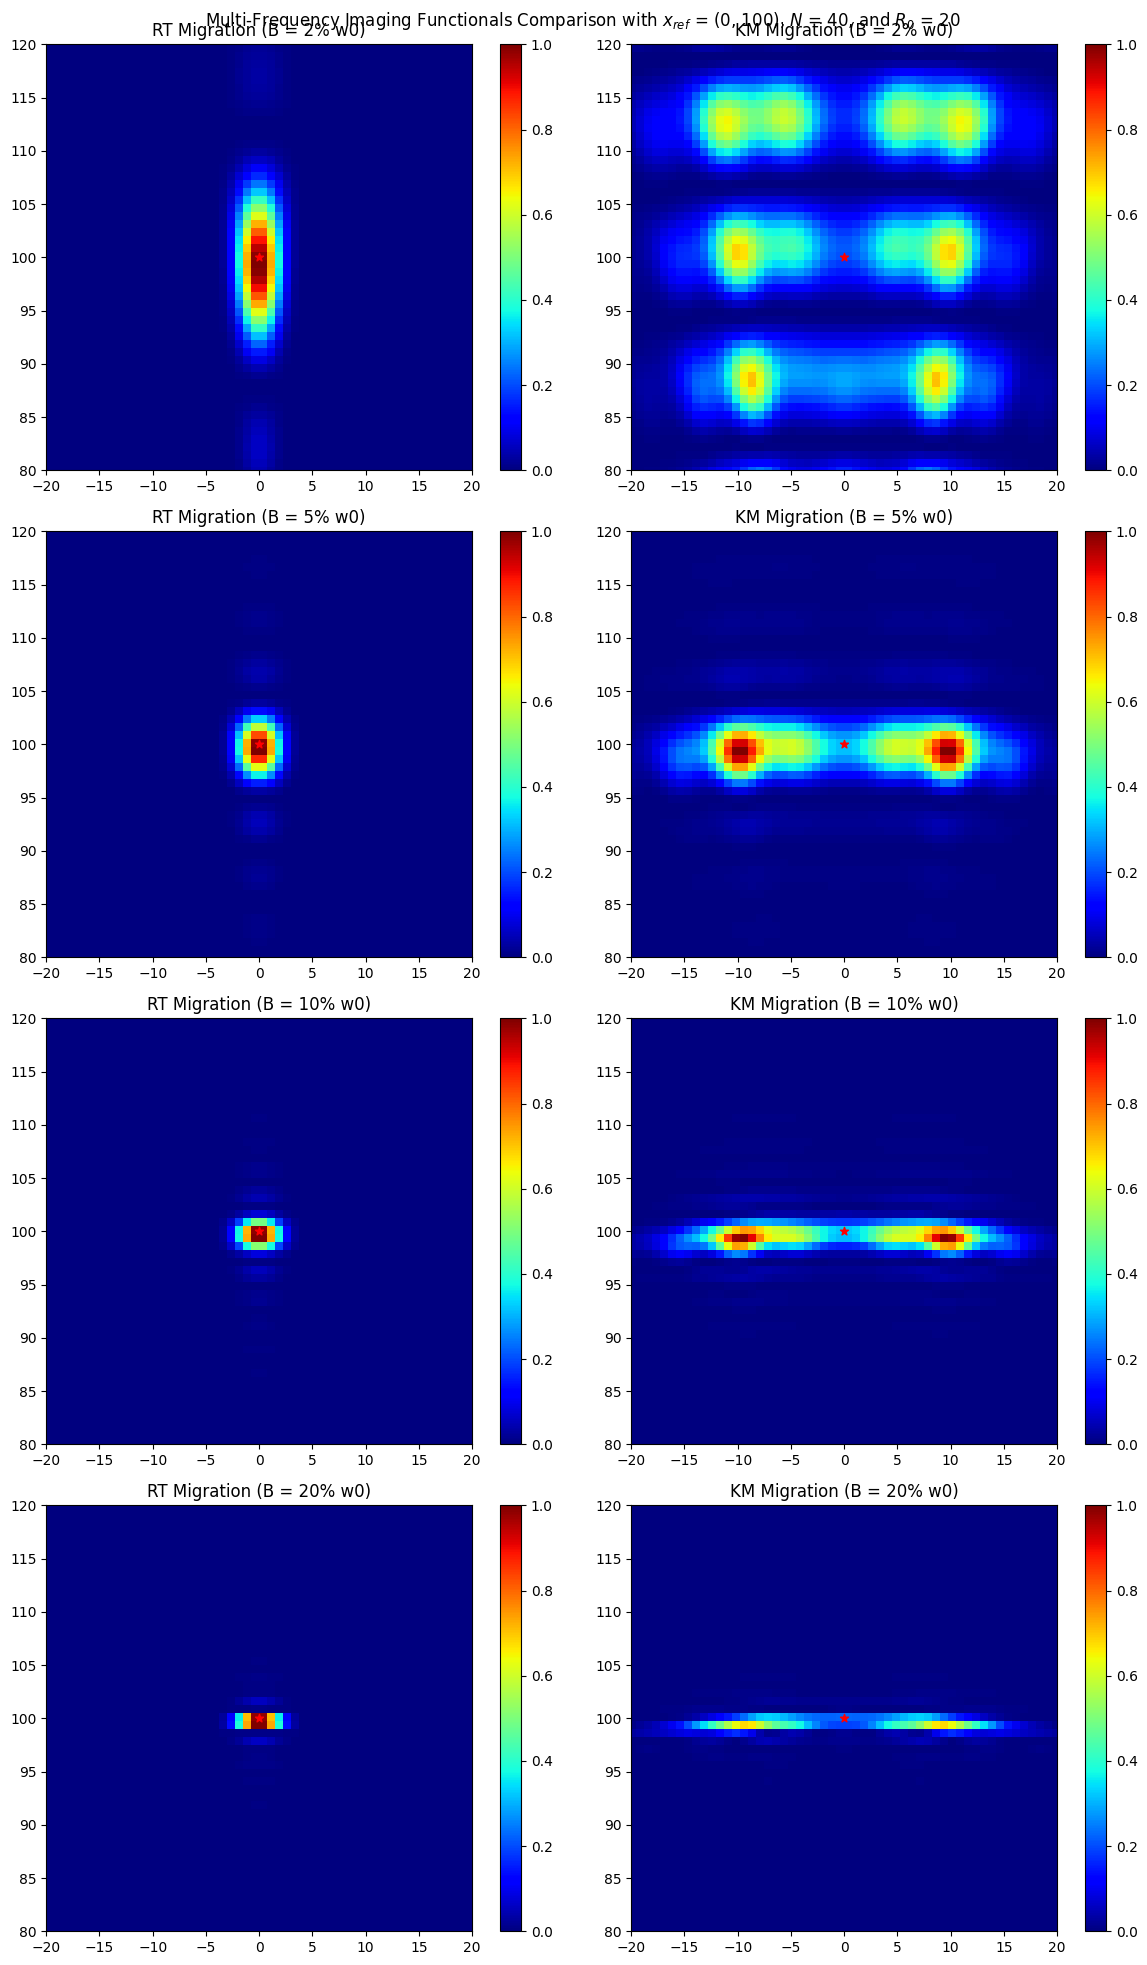

In [45]:
# Bandwidth percentages (all B = percentage * w0)
B_percentages = [0.02, 0.05, 0.1, 0.2]

fig, axes = plt.subplots(len(B_percentages), 2, figsize=(12, 5 * len(B_percentages)))

for idx, perc in enumerate(B_percentages):
    # Bandwidth
    B = perc * w0
    ws = np.linspace(w0 - B, w0 + B, Nw)

    # Reset images
    Image_RT = np.zeros_like(X, dtype=complex)
    Image_KM = np.zeros_like(X, dtype=complex)

    for omega in ws:
        # Data Matrix (Born Approximation)
        dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
        v_t = GreenRT(dist_t_ref, omega)
        U = -(omega**2 / 16) * np.outer(v_t, v_t)

        # Reverse-Time Migration
        g_rt = GreenRT(dists_grid, omega)
        vec_rt = np.conj(g_rt)
        temp_rt = vec_rt @ U
        step_rt = np.sum(vec_rt * temp_rt, axis=2)
        Image_RT += step_rt

        # Kirchhoff Migration
        g_km = GreenKM(dists_grid, omega)
        vec_km = np.conj(g_km)
        temp_km = vec_km @ U
        step_km = np.sum(vec_km * temp_km, axis=2)
        Image_KM += step_km

    # Intensity
    I_RT = np.abs(Image_RT) ** 2
    I_KM = np.abs(Image_KM) ** 2

    # Normalize
    I_RT /= I_RT.max()
    I_KM /= I_KM.max()

    # Reverse-Time Migration (zoom)
    im_rt = axes[idx, 0].imshow(I_RT, extent=(*xlim, *zlim), origin="lower", cmap="jet")
    axes[idx, 0].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
    axes[idx, 0].scatter(*x_ref, color="red", marker="*", label="Reflector")
    axes[idx, 0].set_aspect("equal")
    axes[idx, 0].set_xlim(x_zoom)
    axes[idx, 0].set_ylim(z_zoom)
    axes[idx, 0].set_title(f"RT Migration (B = {int(perc * 100)}% w0)")
    plt.colorbar(im_rt, ax=axes[idx, 0])

    # Kirchhoff Migration (zoom)
    im_km = axes[idx, 1].imshow(I_KM, extent=(*xlim, *zlim), origin="lower", cmap="jet")
    axes[idx, 1].scatter(x_t[:, 0], x_t[:, 1], c="white", s=1)
    axes[idx, 1].scatter(*x_ref, color="red", marker="*", label="Reflector")
    axes[idx, 1].set_aspect("equal")
    axes[idx, 1].set_xlim(x_zoom)
    axes[idx, 1].set_ylim(z_zoom)
    axes[idx, 1].set_title(f"KM Migration (B = {int(perc * 100)}% w0)")
    plt.colorbar(im_km, ax=axes[idx, 1])

fig.suptitle(
    f"Multi-Frequency Imaging Functionals Comparison with $x_{{ref}}$ = {x_ref}, $N$ = {N}, and $R_0$ = {R0}"
)
plt.tight_layout()
plt.savefig("figures/Time_Dependent_Multiple_Bandwidths.png", dpi=300)
plt.show()

<blockquote>

### Numerical implementation and results

We consider again a linear array of $N$ transducers aligned along the $x$-axis, but we now assume that the sources emit a broadband signal with a flat spectrum over the frequency band $[\omega_0 - B, \omega_0 + B]$. The parameters are set to $\omega_0 = 2\pi$, $B = 0.05,\omega_0$, $R_0 = 20$, $N = 40$, and $\bm{x}_{\mathrm{ref}} = (0,100)$.

Figure 1 presents the RT and KM imaging functionals obtained from the broadband data. As in the single-frequency case, the RT and KM images display similar overall spatial distributions, and the mirror image of the reflector remains visible due to the linear geometry of the array. However, the focal spot is significantly more localized than in the monochromatic configuration, the main peak is sharper and the side lobes are substantially reduced. This enhanced resolution results from the increased bandwidth, which provides richer frequency content and improves the ability of the imaging functionals to coherently focus energy at the reflector location. A notable difference between the two methods is observed at the reflector position. The RT image exhibits a single dominant peak, whereas the KM image shows an additional secondary peak, giving the appearance of a duplicated reflector or a split main lobe. This feature can be attributed to the structure of the KM functional, which includes a frequency-dependent weighting term. For a relatively narrow but finite bandwidth, this term may induce constructive interference effects at the reflector location, leading to the formation of two closely spaced maxima.

The subsequent plots display the focal spot profiles along the $x$ and $z$-directions, together with their theoretical counterparts. Along the $x$-direction, the RT profile accurately reproduces the main peak at the reflector position but does not capture the secondary lobes predicted by the theoretical model. This discrepancy is consistent with the finite and discrete nature of the array. With only $N=40$ transducers distributed over the limited aperture $R_0=20$, spatial sampling effects introduce irregular interference patterns that may suppress or distort the sidelobe structure. Furthermore, broadband integration tends to average out oscillatory features that would be more pronounced at individual frequencies. Along the $z$-direction, the RT profile again shows a primary maximum at the reflector location and a secondary peak at the symmetric position with respect to the origin, reflecting the geometrical symmetry of the array. In this case, however, the theoretical profile predicts a sinc-type behavior that is well reproduced by the RT functional. This agreement indicates that the increased bandwidth enables the imaging process to approach the theoretical resolution limit in the range direction.

Figure 2 illustrates the influence of the bandwidth $B$ on the imaging functionals. As $B$ increases, the focal spot becomes more localized, with sharper main peaks and reduced sidelobes. This trend is consistent with theoretical expectations: a broader bandwidth enhances range resolution by enabling more effective temporal focusing of the wave field. The effect is particularly pronounced for the RT functional, which directly integrates the Green’s function over frequency and therefore benefits strongly from increased spectral diversity. The KM functional exhibits a similar evolution, with the two peaks at the reflector location becoming more distinct and better defined as the bandwidth increases.

Overall, these results demonstrate the significant impact of bandwidth on the resolution and structure of RT and KM imaging functionals, highlighting the importance of broadband data for achieving high-resolution reconstructions in time-dependent localization problems.

</blockquote>

---
## 5) Stability with respect to measurement noise

Consider measurement noise. The recorded signals are $\hat{u}_{rs}(\omega) + W_{rs}^{(1)}(\omega) + i W_{rs}^{(2)}(\omega)$, where the noise terms $W_{rs}^{(1)}(\omega), W_{rs}^{(2)}(\omega)$ are independent and identically distributed Gaussian random variables with mean zero and variance $\sigma^2 /2$.

Revisit the previous questions in the presence of measurement noise and study the stability issue (up to you: establish the statistics of the localization error, the dependence of the standard deviation in the localization error with respect to the number of sensors, with respect to the bandwidth, and so on, compare MUSIC and RT, ...).

In [46]:
def add_noise(U, sigma):
    """Adds complex Gaussian noise with variance sigma^2."""
    noise_real = np.random.normal(0, sigma / np.sqrt(2), U.shape)
    noise_imag = np.random.normal(0, sigma / np.sqrt(2), U.shape)
    return U + (noise_real + 1j * noise_imag)

#### Full aperture (Section 2) with noise

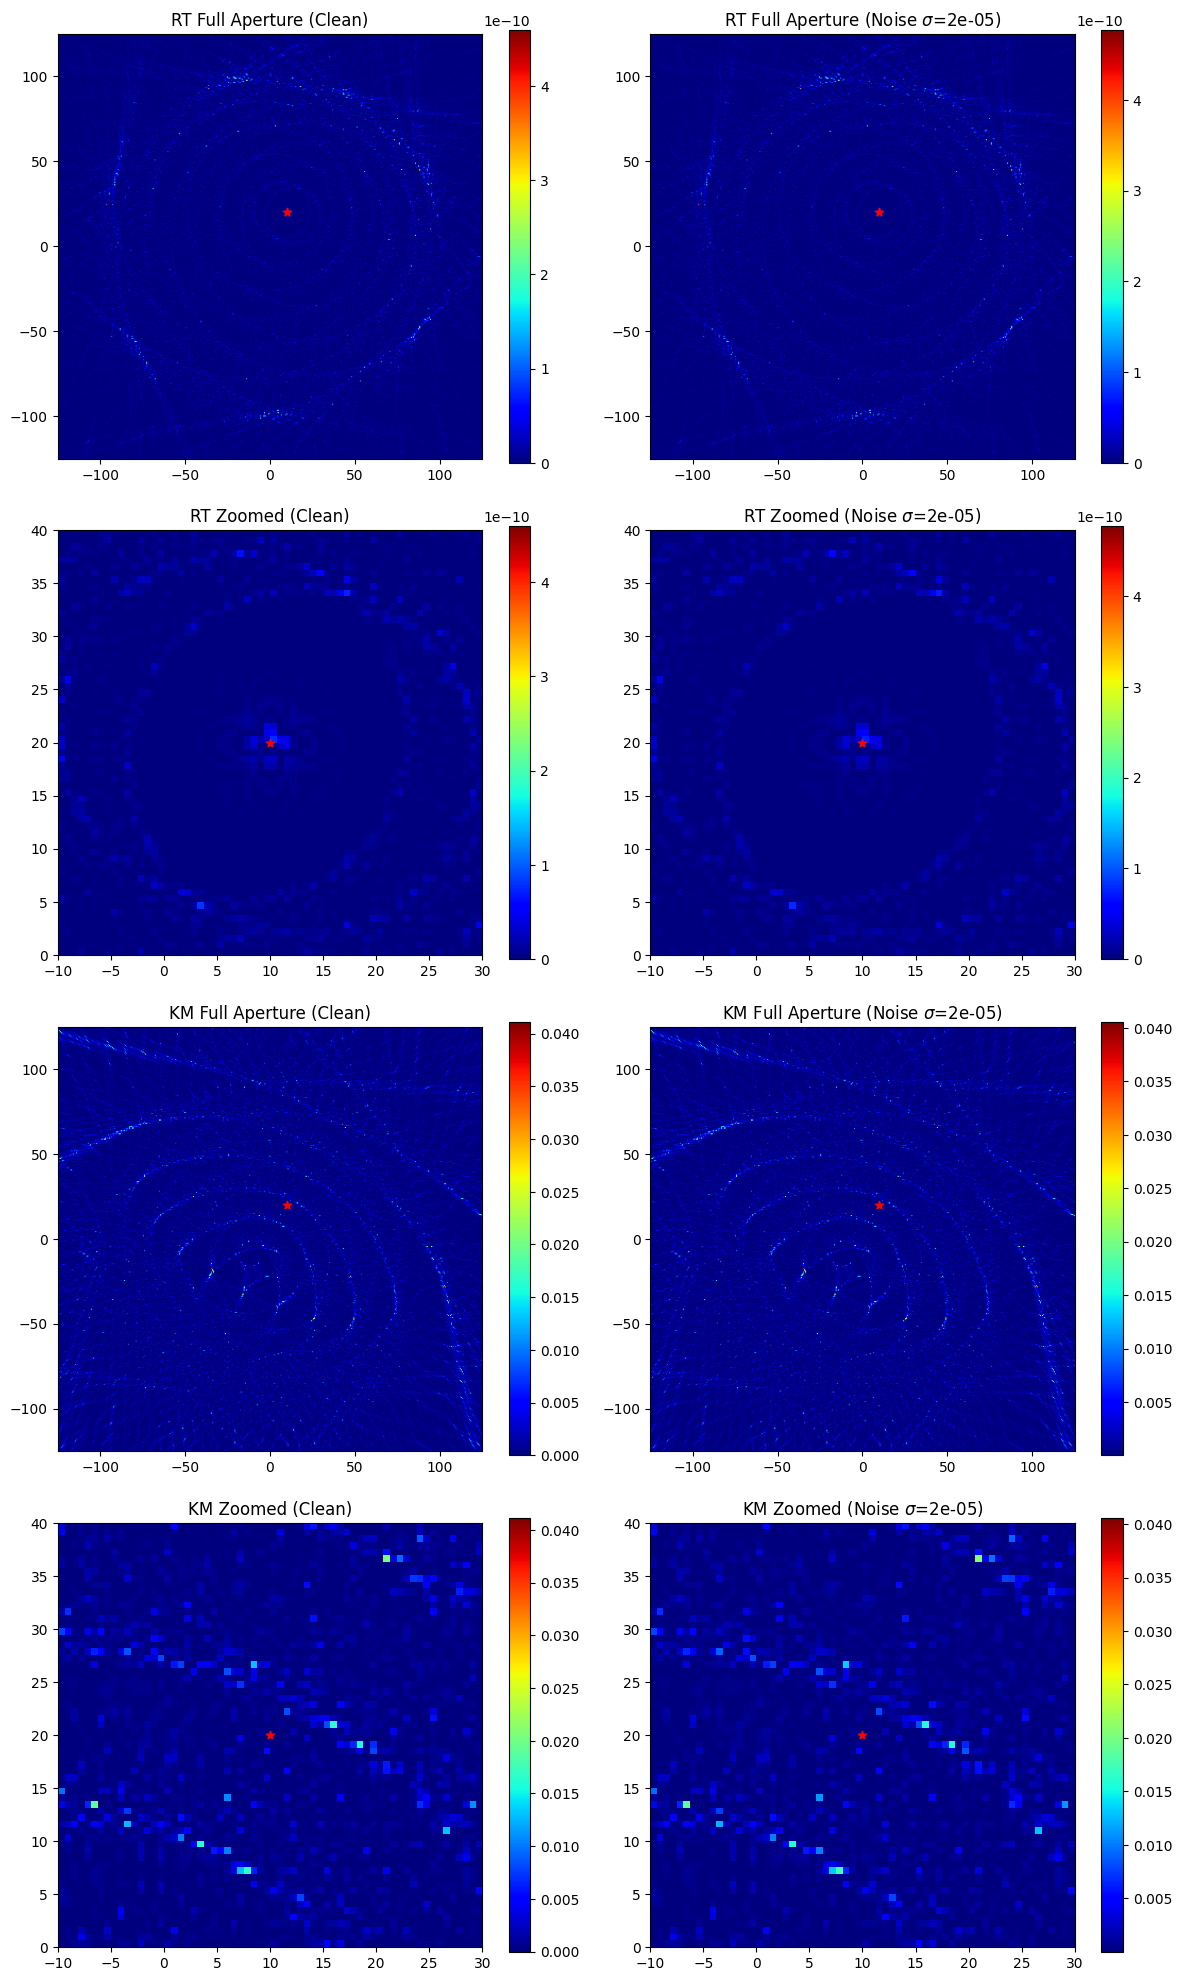

In [47]:
# Parameters
N = 100  # Number of transducers
w = 2 * np.pi  # Frequency
R0 = 100  # Array radius
x_ref = (10, 20)  # Point-like reflector position

theta_t = np.linspace(0, 2 * np.pi, N, endpoint=False)  # Angles for transducers
x_t = np.stack(
    (R0 * np.cos(theta_t), R0 * np.sin(theta_t)), axis=-1
)  # Transducer positions

# Grid parameters for imaging
n = 400
xlim = (-125, 125)
zlim = (-125, 125)
x = np.linspace(xlim[0], xlim[1], n)
z = np.linspace(zlim[0], zlim[1], n)
X, Z = np.meshgrid(x, z)

# Define zoom window size
zoom_half_width = 20
x_zoom = (x_ref[0] - zoom_half_width, x_ref[0] + zoom_half_width)
z_zoom = (x_ref[1] - zoom_half_width, x_ref[1] + zoom_half_width)

# Generate Clean Data
dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
v_t = GreenRT(dist_t_ref, w)
U_clean = -(w**2 / 16) * np.outer(v_t, v_t)

# Add Noise
sigma = 0.1 * np.max(np.abs(U_clean))  # ADJUST THIS FACTOR TO CHANGE THE NOISE LEVEL
U_noisy = add_noise(U_clean, sigma)

# Imaging Functionals with noise
I_RT_noisy = np.zeros_like(X, dtype=float)

# Precompute Green's functions
grid_points = np.stack((X.flatten(), Z.flatten()), axis=1)
dists_grid = np.linalg.norm(grid_points[:, None, :] - x_t[None, :, :], axis=2)
G_grid = GreenRT(dists_grid, w)

# Vectorized RT Calculation
G_conj = np.conj(G_grid)

# Clean RT
temp = G_conj @ U_clean
I_RT_flat = np.abs(np.sum(temp * G_conj, axis=1)) ** 2
I_RT_clean = I_RT_flat.reshape(X.shape)

# Noisy RT
temp = G_conj @ U_noisy
I_RT_flat = np.abs(np.sum(temp * G_conj, axis=1)) ** 2
I_RT_noisy = I_RT_flat.reshape(X.shape)

# Vectorized Kirchhoff Calculation
G_km = GreenKM(dists_grid, w)
G_km_conj = np.conj(G_km)

# Clean Kirchhoff
temp_km = G_km_conj @ U_clean
I_KM_flat = np.abs(np.sum(temp_km * G_km_conj, axis=1)) ** 2
I_KM_clean = I_KM_flat.reshape(X.shape)

# Noisy Kirchhoff
temp_km = G_km_conj @ U_noisy
I_KM_flat = np.abs(np.sum(temp_km * G_km_conj, axis=1)) ** 2
I_KM_noisy = I_KM_flat.reshape(X.shape)

# Plotting
fig, ax = plt.subplots(4, 2, figsize=(12, 20))

im0 = ax[0, 0].imshow(
    I_RT_clean, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
ax[0, 0].set_title("RT Full Aperture (Clean)")
ax[0, 0].scatter(*x_ref, c="r", marker="*")
plt.colorbar(im0, ax=ax[0, 0])

im1 = ax[0, 1].imshow(
    I_RT_noisy, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
ax[0, 1].set_title(f"RT Full Aperture (Noise $\\sigma$={sigma:.2g})")
ax[0, 1].scatter(*x_ref, c="r", marker="*")
plt.colorbar(im1, ax=ax[0, 1])

# Zoomed Clean
im2 = ax[1, 0].imshow(
    I_RT_clean, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
ax[1, 0].set_title("RT Zoomed (Clean)")
ax[1, 0].scatter(*x_ref, c="r", marker="*")
ax[1, 0].set_xlim(x_zoom)
ax[1, 0].set_ylim(z_zoom)
plt.colorbar(im2, ax=ax[1, 0])

# Zoomed Noisy
im3 = ax[1, 1].imshow(
    I_RT_noisy, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
ax[1, 1].set_title(f"RT Zoomed (Noise $\\sigma$={sigma:.2g})")
ax[1, 1].scatter(*x_ref, c="r", marker="*")
ax[1, 1].set_xlim(x_zoom)
ax[1, 1].set_ylim(z_zoom)
plt.colorbar(im3, ax=ax[1, 1])

# Kirchhoff Clean
im4 = ax[2, 0].imshow(
    I_KM_clean, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
ax[2, 0].set_title("KM Full Aperture (Clean)")
ax[2, 0].scatter(*x_ref, c="r", marker="*")
plt.colorbar(im4, ax=ax[2, 0])

# Kirchhoff Noisy
im5 = ax[2, 1].imshow(
    I_KM_noisy, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
ax[2, 1].set_title(f"KM Full Aperture (Noise $\\sigma$={sigma:.2g})")
ax[2, 1].scatter(*x_ref, c="r", marker="*")
plt.colorbar(im5, ax=ax[2, 1])

# Zoomed Kirchhoff Clean
im6 = ax[3, 0].imshow(
    I_KM_clean, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
ax[3, 0].set_title("KM Zoomed (Clean)")
ax[3, 0].scatter(*x_ref, c="r", marker="*")
ax[3, 0].set_xlim(x_zoom)
ax[3, 0].set_ylim(z_zoom)
plt.colorbar(im6, ax=ax[3, 0])

# Zoomed Kirchhoff Noisy
im7 = ax[3, 1].imshow(
    I_KM_noisy, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
ax[3, 1].set_title(f"KM Zoomed (Noise $\\sigma$={sigma:.2g})")
ax[3, 1].scatter(*x_ref, c="r", marker="*")
ax[3, 1].set_xlim(x_zoom)
ax[3, 1].set_ylim(z_zoom)
plt.colorbar(im7, ax=ax[3, 1])

plt.tight_layout()
plt.savefig("figures/Noise_Full_Aperture.png", dpi=300)
plt.show()

#### Partial aperture (Section 3) with noise

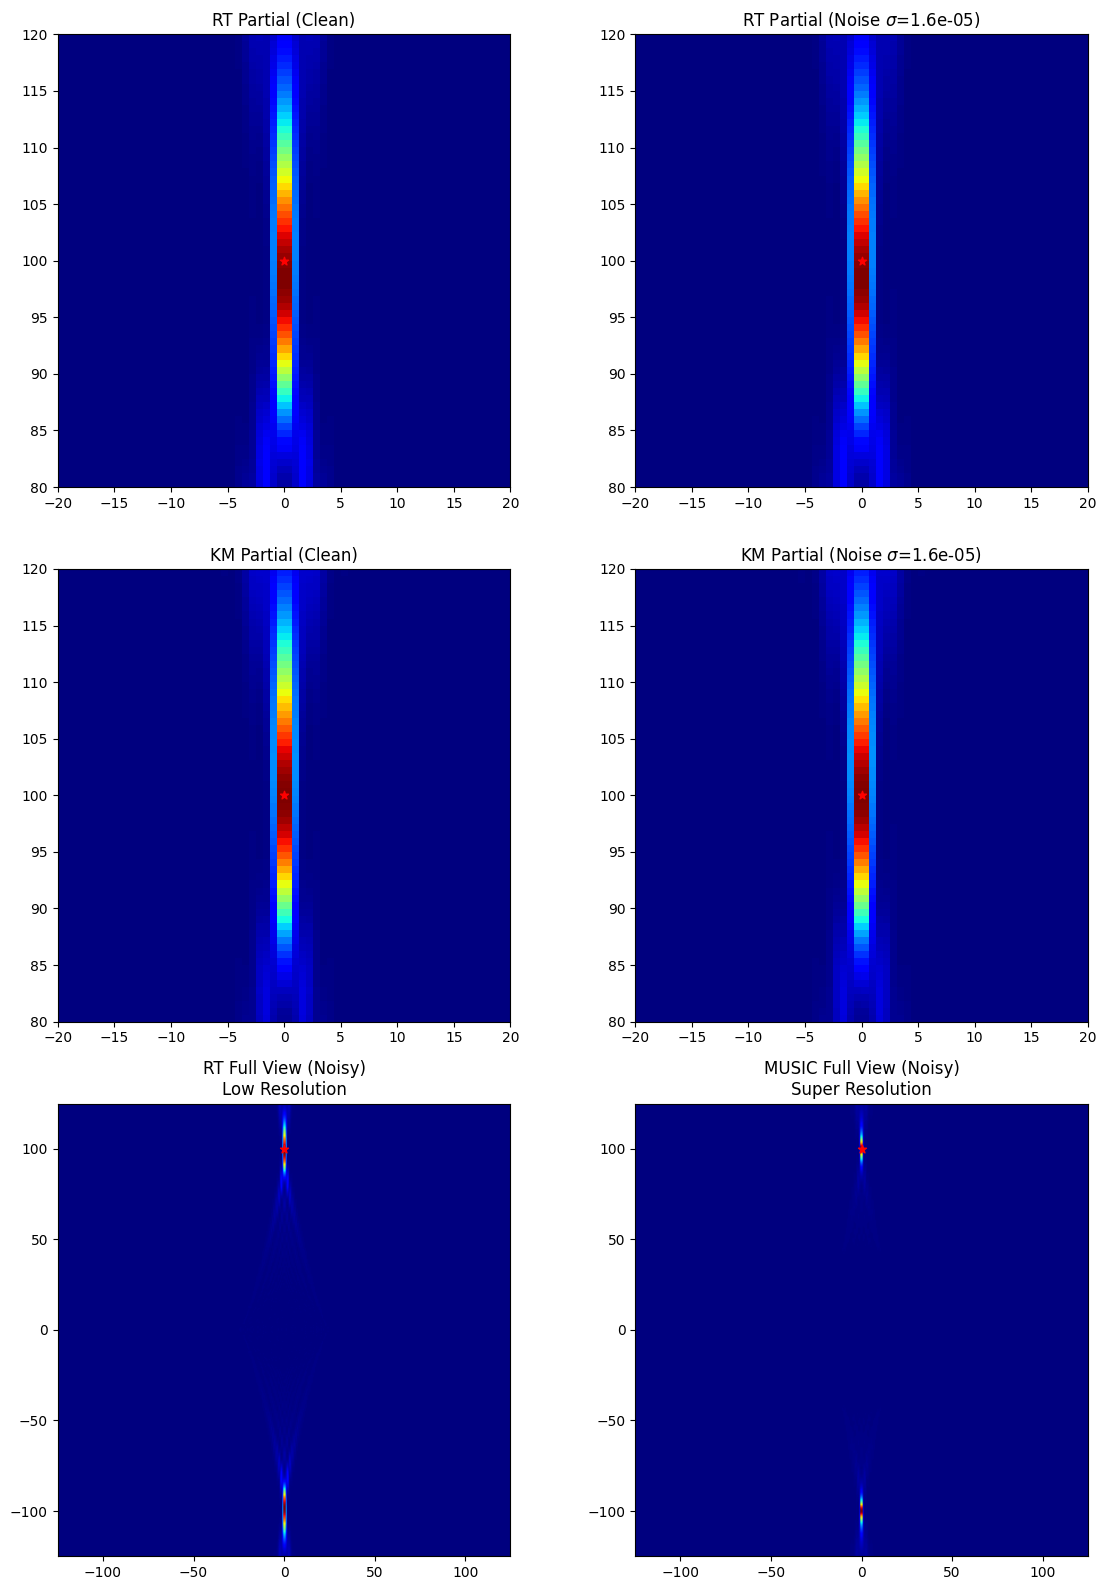

In [48]:
# Parameters
N = 100  # Number of transducers
w = 2 * np.pi  # Frequency
R0 = 50  # Array radius
x_ref = (0, 100)  # Point-like reflector position

x_coords = np.linspace(-R0 / 2, R0 / 2, N)  # Transducer x-coordinates
x_t = np.stack((x_coords, np.zeros(N)), axis=-1)  # Transducer positions

# Grid parameters for imaging
n = 400
xlim = (-125, 125)
zlim = (-125, 125)
x = np.linspace(xlim[0], xlim[1], n)
z = np.linspace(zlim[0], zlim[1], n)
X, Z = np.meshgrid(x, z)

# Define zoom window size
zoom_half_width = 20

x_zoom = (x_ref[0] - zoom_half_width, x_ref[0] + zoom_half_width)
z_zoom = (x_ref[1] - zoom_half_width, x_ref[1] + zoom_half_width)

# Generate Data
dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
v_t = GreenRT(dist_t_ref, w)
U_clean = -(w**2 / 16) * np.outer(v_t, v_t)

# Add Noise
sigma = 0.1 * np.max(np.abs(U_clean))  # ADJUST THIS FACTOR TO CHANGE THE NOISE LEVEL
U_noisy = add_noise(U_clean, sigma)

# Precompute Grid Green's Functions
grid_points = np.stack((X.flatten(), Z.flatten()), axis=1)
dists_grid = np.linalg.norm(grid_points[:, None, :] - x_t[None, :, :], axis=2)

# Reverse Time Migration
G_rt = GreenRT(dists_grid, w)
G_rt_conj = np.conj(G_rt)
# Clean
temp = G_rt_conj @ U_clean
I_RT_clean = np.abs(np.sum(temp * G_rt_conj, axis=1)) ** 2
I_RT_clean = I_RT_clean.reshape(X.shape)
# Noisy
temp = G_rt_conj @ U_noisy
I_RT_noisy = np.abs(np.sum(temp * G_rt_conj, axis=1)) ** 2
I_RT_noisy = I_RT_noisy.reshape(X.shape)

# Kirchhoff Migration
G_km = GreenKM(dists_grid, w)
# Clean
temp = G_km @ U_clean
I_KM_clean = np.abs(np.sum(temp * G_km, axis=1)) ** 2
I_KM_clean = I_KM_clean.reshape(X.shape)
# Noisy
temp = G_km @ U_noisy
I_KM_noisy = np.abs(np.sum(temp * G_km, axis=1)) ** 2
I_KM_noisy = I_KM_noisy.reshape(X.shape)

# MUSIC
u, s, vh = np.linalg.svd(U_noisy)
u1 = u[:, 0]
norms_g = np.linalg.norm(G_rt, axis=1)
G_norm = G_rt / norms_g[:, None]
proj = G_norm @ u1.conj()
denom = 1.0 - np.abs(proj) ** 2
denom = np.maximum(denom, 1e-6)
I_MUSIC = 1.0 / denom
I_MUSIC = I_MUSIC.reshape(X.shape)


# Visualization
fig, ax = plt.subplots(3, 2, figsize=(12, 16))

# Row 1: RT (Clean vs Noisy) - Zoomed
ax[0, 0].imshow(I_RT_clean, extent=xlim + zlim, origin="lower", cmap="jet")
ax[0, 0].set_title("RT Partial (Clean)")
ax[0, 0].scatter(*x_ref, c="r", marker="*")
ax[0, 0].set_xlim(x_zoom)
ax[0, 0].set_ylim(z_zoom)

ax[0, 1].imshow(I_RT_noisy, extent=xlim + zlim, origin="lower", cmap="jet")
ax[0, 1].set_title(f"RT Partial (Noise $\\sigma$={sigma:.2g})")
ax[0, 1].scatter(*x_ref, c="r", marker="*")
ax[0, 1].set_xlim(x_zoom)
ax[0, 1].set_ylim(z_zoom)

# Row 2: KM (Clean vs Noisy) - Zoomed
ax[1, 0].imshow(I_KM_clean, extent=xlim + zlim, origin="lower", cmap="jet")
ax[1, 0].set_title("KM Partial (Clean)")
ax[1, 0].scatter(*x_ref, c="r", marker="*")
ax[1, 0].set_xlim(x_zoom)
ax[1, 0].set_ylim(z_zoom)

ax[1, 1].imshow(I_KM_noisy, extent=xlim + zlim, origin="lower", cmap="jet")
ax[1, 1].set_title(f"KM Partial (Noise $\\sigma$={sigma:.2g})")
ax[1, 1].scatter(*x_ref, c="r", marker="*")
ax[1, 1].set_xlim(x_zoom)
ax[1, 1].set_ylim(z_zoom)

# Row 3: Comparison (Full View) - RT vs MUSIC
ax[2, 0].imshow(I_RT_noisy, extent=xlim + zlim, origin="lower", cmap="jet")
ax[2, 0].set_title("RT Full View (Noisy)\nLow Resolution")
ax[2, 0].scatter(*x_ref, c="r", marker="*")
ax[2, 0].set_aspect("equal")  # Correct aspect ratio

ax[2, 1].imshow(I_MUSIC, extent=xlim + zlim, origin="lower", cmap="jet")
ax[2, 1].set_title("MUSIC Full View (Noisy)\nSuper Resolution")
ax[2, 1].scatter(*x_ref, c="r", marker="*")
ax[2, 1].set_aspect("equal")

plt.tight_layout()
plt.savefig("figures/Noise_Partial_Aperture.png", dpi=300)
plt.show()

#### Time-dependent localization and partial aperture (Section 4) with noise

In [49]:
# Parameters
N = 40  # Number of receivers
w0 = 2 * np.pi  # Center frequency
B = 0.05 * w0  # Bandwidth
Nw = 20  # Number of frequency samples (as requested by prompt)
ws = np.linspace(w0 - B, w0 + B, Nw)

R0 = 20  # Array length
x_ref = (0, 100)  # Reflector position

# Transducer positions
x_coords = np.linspace(-R0 / 2, R0 / 2, N)
x_t = np.stack((x_coords, np.zeros(N)), axis=-1)

# Grid parameters (Zoomed around the reflector)
n = 150
xlim = (-40, 40)
zlim = (60, 140)
x = np.linspace(xlim[0], xlim[1], n)
z = np.linspace(zlim[0], zlim[1], n)
X, Z = np.meshgrid(x, z)

grid_points = np.stack((X.flatten(), Z.flatten()), axis=1)
dists_grid = np.linalg.norm(grid_points[:, None, :] - x_t[None, :, :], axis=2)

# Compute max amplitude of the clean data at the center frequency to scale the noise
dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
v_t_c = (1j / 4) * hankel1(0, w0 * dist_t_ref)
U_clean_c = -(w0**2 / 16) * np.outer(v_t_c, v_t_c)
sigma = 0.5 * np.max(
    np.abs(U_clean_c)
)  # ADJUST THE FACTOR TO CHANGE THE ADAPTIVE NOISE LEVEL

# Initialization
Complex_RT = np.zeros(grid_points.shape[0], dtype=complex)
Complex_KM = np.zeros(grid_points.shape[0], dtype=complex)
Denom_MU = np.zeros(grid_points.shape[0], dtype=float)

for omega in ws:
    # Generate Clean Data
    v_t = (1j / 4) * hankel1(0, omega * dist_t_ref)
    U_clean = -(omega**2 / 16) * np.outer(v_t, v_t)

    # Add Noise
    U_noisy = add_noise(U_clean, sigma)

    # Precompute Green's functions
    G = (1j / 4) * hankel1(0, omega * dists_grid)
    G_conj = np.conj(G)

    G_km = np.exp(-1j * omega * dists_grid)
    G_km_conj = np.conj(G_km)

    # Coherent Accumulation for RT and KM
    temp_rt = G_conj @ U_noisy
    Complex_RT += np.sum(temp_rt * G_conj, axis=1)

    temp_km = G_km_conj @ U_noisy
    Complex_KM += np.sum(temp_km * G_km_conj, axis=1)

    # Incoherent Accumulation for MUSIC
    u_svd, s_svd, vh_svd = np.linalg.svd(U_noisy)
    u1 = u_svd[:, 0]

    norms_g = np.linalg.norm(G, axis=1)
    G_norm = G / norms_g[:, None]

    proj = np.abs(G_norm @ u1.conj()) ** 2
    Denom_MU += 1.0 - proj

# Finalize Images
I_RT = np.abs(Complex_RT) ** 2
I_KM = np.abs(Complex_KM) ** 2

# Incoherent MUSIC: Inverse of the averaged noise projection
Denom_MU_avg = Denom_MU / Nw
Denom_MU_avg = np.maximum(Denom_MU_avg, 1e-6)
I_MU = 1.0 / Denom_MU_avg

# Reshape
I_RT = I_RT.reshape(X.shape)
I_KM = I_KM.reshape(X.shape)
I_MU = I_MU.reshape(X.shape)

# Normalize
I_RT /= I_RT.max()
I_KM /= I_KM.max()
I_MU /= I_MU.max()

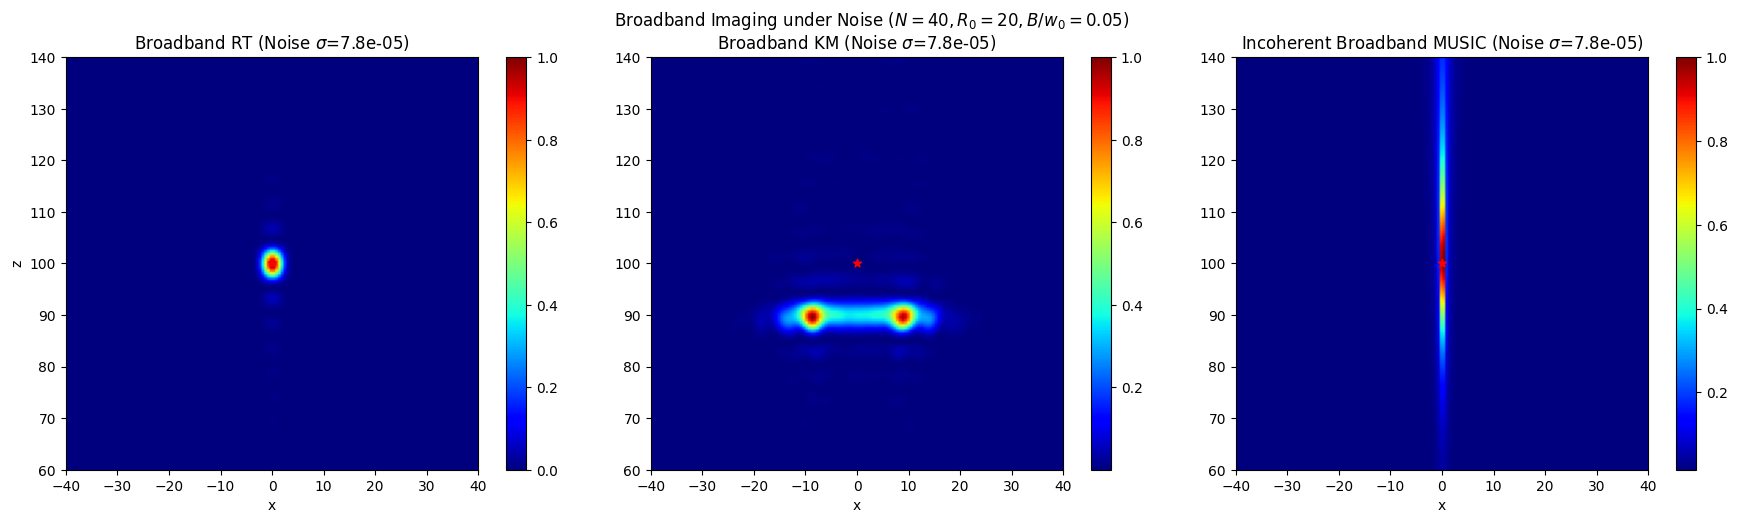

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im0 = axes[0].imshow(
    I_RT, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[0].set_title(f"Broadband RT (Noise $\\sigma$={sigma:.2g})")
axes[0].scatter(*x_ref, color="red", marker="*")
axes[0].set_xlabel("x")
axes[0].set_ylabel("z")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(
    I_KM, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[1].set_title(f"Broadband KM (Noise $\\sigma$={sigma:.2g})")
axes[1].scatter(*x_ref, color="red", marker="*")
axes[1].set_xlabel("x")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(
    I_MU, extent=(xlim[0], xlim[1], zlim[0], zlim[1]), origin="lower", cmap="jet"
)
axes[2].set_title(f"Incoherent Broadband MUSIC (Noise $\\sigma$={sigma:.2g})")
axes[2].scatter(*x_ref, color="red", marker="*")
axes[2].set_xlabel("x")
plt.colorbar(im2, ax=axes[2])

fig.suptitle(f"Broadband Imaging under Noise ($N={N}, R_0={R0}, B/w_0=0.05$)")
plt.tight_layout()
plt.savefig("figures/Noise_Time_Dependent.png", dpi=300)
plt.show()

#### Monte Carlo simulation for Stability Analysis

In [51]:
# Parameters
N = 100  # Number of transducers
w = 2 * np.pi  # Frequency
R0 = 50  # Array length (linear array)
x_ref = (0, 100)  # Point-like reflector position

# Transducer positions (linear array along x-axis)
x_coords = np.linspace(-R0 / 2, R0 / 2, N)
x_t = np.stack((x_coords, np.zeros(N)), axis=-1)

# Generate Clean Data
dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
v_t = (1j / 4) * hankel1(0, w * dist_t_ref)
U_clean = -(w**2 / 16) * np.outer(v_t, v_t)

# Search Grid focused around the reflector
search_radius = 20
n_search = 50
xs = np.linspace(x_ref[0] - search_radius, x_ref[0] + search_radius, n_search)
zs = np.linspace(x_ref[1] - search_radius, x_ref[1] + search_radius, n_search)
XS, ZS = np.meshgrid(xs, zs)
grid_points_search = np.stack((XS.flatten(), ZS.flatten()), axis=1)

# Green's Function Matrix
dists_search = np.linalg.norm(grid_points_search[:, None, :] - x_t[None, :, :], axis=2)
G_search = (1j / 4) * hankel1(0, w * dists_search)
G_search_conj = np.conj(G_search)

# Normalize Green's functions for MUSIC
norms_g = np.linalg.norm(G_search, axis=1, keepdims=True)
G_search_norm = G_search / norms_g

# Simulation parameters
max_amp = np.max(np.abs(U_clean))
noise_levels = np.linspace(0, max_amp * 10, 30)
n_trials = 100

rmse_rt = []
rmse_mu = []

for sigma in tqdm(noise_levels):
    errors_rt = []
    errors_mu = []

    for _ in range(n_trials):
        # Generate Noisy Data
        if sigma > 0:
            noise_real = np.random.normal(0, sigma / np.sqrt(2), U_clean.shape)
            noise_imag = np.random.normal(0, sigma / np.sqrt(2), U_clean.shape)
            U_noisy = U_clean + (noise_real + 1j * noise_imag)
        else:
            U_noisy = U_clean.copy()

        # MUSIC Estimator (noise-subspace formulation)
        u_svd, s_svd, vh_svd = np.linalg.svd(U_noisy)
        u1 = u_svd[:, 0]

        # Noise-subspace MUSIC: I_MU = 1 / (1 - |<g_norm, u1>|^2)
        proj = np.abs(G_search_norm @ u1.conj()) ** 2
        denom = np.maximum(1.0 - proj, 1e-10)
        I_MU = 1.0 / denom
        est_mu = grid_points_search[np.argmax(I_MU)]
        errors_mu.append(np.linalg.norm(est_mu - np.array(x_ref)))

        # Reverse-Time Migration Estimator
        temp_rt = G_search_conj @ U_noisy
        I_RT_search = np.abs(np.sum(temp_rt * G_search_conj, axis=1)) ** 2
        est_rt = grid_points_search[np.argmax(I_RT_search)]
        errors_rt.append(np.linalg.norm(est_rt - np.array(x_ref)))

    # Calculate RMSE
    rmse_rt.append(np.sqrt(np.mean(np.array(errors_rt) ** 2)))
    rmse_mu.append(np.sqrt(np.mean(np.array(errors_mu) ** 2)))

100%|██████████| 30/30 [00:07<00:00,  3.94it/s]


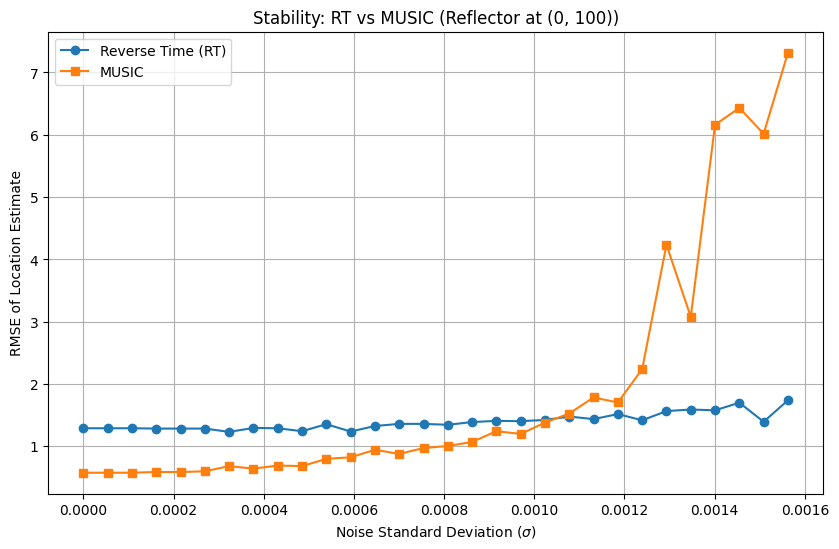

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, rmse_rt, "-o", label="Reverse Time (RT)")
plt.plot(noise_levels, rmse_mu, "-s", label="MUSIC")
plt.xlabel(r"Noise Standard Deviation ($\sigma$)")
plt.ylabel("RMSE of Location Estimate")
plt.title(f"Stability: RT vs MUSIC (Reflector at {x_ref})")
plt.legend()
plt.grid(True)
plt.savefig("figures/Stability_vs_Noise.png", dpi=300)
plt.show()

In [53]:
def rtm_svd(U, X, Z, x_t, omega):
    """
    SVD-based Reverse-Time Migration Imaging Functional.

    Args:
        U: Data matrix (N_transducers x N_transducers)
        X, Z: Meshgrid of coordinates
        x_t: Transducer positions (N_transducers x 2)
        omega: Frequency
    """
    # Singular Value Decomposition
    u, sigma, vh = np.linalg.svd(U)
    v = vh.conj().T

    n_receivers = x_t.shape[0]
    output_shape = X.shape
    grid_points = np.stack((X.flatten(), Z.flatten()), axis=1)

    # Precompute Green's Functions for all receivers to all grid points
    dists = np.linalg.norm(grid_points[None, :, :] - x_t[:, None, :], axis=2)
    G = (1j / 4) * hankel1(0, omega * dists)

    factor_renorm = np.sum(np.abs(G) ** 2, axis=0)

    Imag_Mat = np.zeros(grid_points.shape[0], dtype=complex)

    # Sum over singular values
    G_conj = np.conj(G)

    for k in range(len(sigma)):
        if sigma[k] < 1e-10:
            continue

        im_left = G_conj.T @ u[:, k]
        im_right = G_conj.T @ np.conj(v[:, k])

        Imag_Mat += sigma[k] * (im_left * im_right) / factor_renorm

    return np.abs(Imag_Mat).reshape(output_shape)


def km_svd(U, X, Z, x_t, omega):
    """
    SVD-based Kirchhoff Migration Imaging Functional.
    """
    u, sigma, vh = np.linalg.svd(U)
    v = vh.conj().T

    n_receivers = x_t.shape[0]
    output_shape = X.shape
    grid_points = np.stack((X.flatten(), Z.flatten()), axis=1)

    dists = np.linalg.norm(grid_points[None, :, :] - x_t[:, None, :], axis=2)

    D_mat = np.exp(1j * omega * dists) / np.sqrt(n_receivers)
    D_conj = np.conj(D_mat)

    Imag_Mat = np.zeros(grid_points.shape[0], dtype=complex)

    for k in range(len(sigma)):
        if sigma[k] < 1e-10:
            continue

        im_left = D_conj.T @ u[:, k]
        im_right = D_conj.T @ np.conj(v[:, k])

        Imag_Mat += sigma[k] * (im_left * im_right)

    return np.abs(Imag_Mat).reshape(output_shape)

Direct Time: 0.5179s
SVD Time: 0.4997s
Speedup: 1.04x


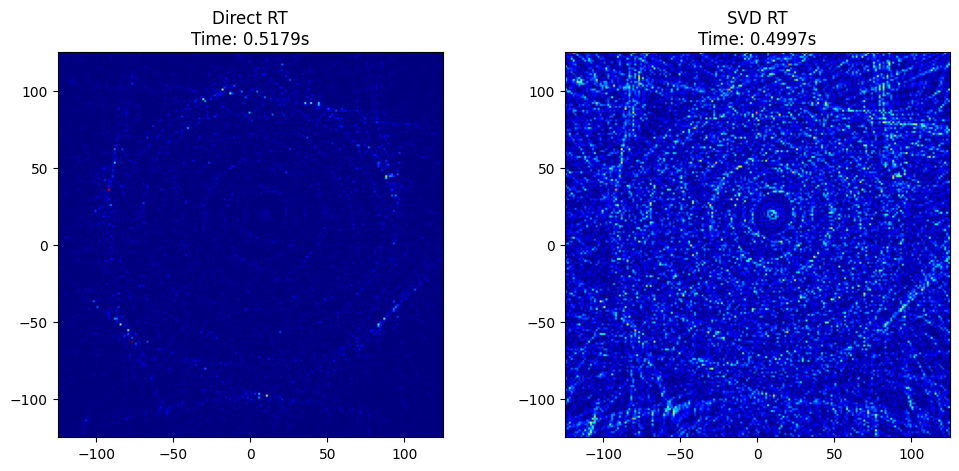

In [54]:
# Parameters
N = 100
w = 2 * np.pi
R0 = 100
x_ref = (10, 20)

# Array
theta_t = np.linspace(0, 2 * np.pi, N, endpoint=False)
x_t = np.stack((R0 * np.cos(theta_t), R0 * np.sin(theta_t)), axis=-1)

# Grid
n_grid = 200
x = np.linspace(-125, 125, n_grid)
z = np.linspace(-125, 125, n_grid)
X, Z = np.meshgrid(x, z)

# Generate Data
dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
v_t = (1j / 4) * hankel1(0, w * dist_t_ref)
U = -(w**2 / 16) * np.outer(v_t, v_t)


# Direct Reverse-Time Migration
t0 = time()
grid_points = np.stack((X.flatten(), Z.flatten()), axis=1)
dists_g = np.linalg.norm(grid_points[None, :, :] - x_t[:, None, :], axis=2)
G_g = (1j / 4) * hankel1(0, w * dists_g)
G_vec = np.conj(G_g)
temp = G_vec.T @ U
I_RT_Direct = np.abs(np.sum(temp * G_vec.T, axis=1)) ** 2
I_RT_Direct = I_RT_Direct.reshape(X.shape)
t_direct = time() - t0

# SVD Reverse-Time Migration
t1 = time()
I_RT_SVD = rtm_svd(U, X, Z, x_t, w)
t_svd = time() - t1

print(f"Direct Time: {t_direct:.4f}s")
print(f"SVD Time: {t_svd:.4f}s")
print(f"Speedup: {t_direct / t_svd:.2f}x")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(I_RT_Direct, extent=(-125, 125, -125, 125), origin="lower", cmap="jet")
axes[0].set_title(f"Direct RT\nTime: {t_direct:.4f}s")
axes[1].imshow(I_RT_SVD, extent=(-125, 125, -125, 125), origin="lower", cmap="jet")
axes[1].set_title(f"SVD RT\nTime: {t_svd:.4f}s")
plt.savefig("figures/SVD_RT_Comparison.png", dpi=300)
plt.show()

<blockquote>


**Note for Partial aperture with noise.** We use the classical noise-subspace MUSIC algorithm: $\mathcal{I}_{MU}(x) = 1 / (1 - |\langle \hat{g}(\omega, x), v_1 \rangle|^2)$, where $v_1$ is the first singular vector of the response matrix $\hat{u}$. Though the instructions define the MUSIC-type functional as a projection onto the first singular vector (the signal subspace), and while this effectively isolates the signal, it behaves as a matched filter and remains diffraction-limited. To rigorously investigate the stability and super-resolution properties requested in this section, we implement the algorithm as defined in [1]. This allows us to observe the true high-resolution capabilities of MUSIC and provides a much starker contrast to the Reverse-Time migration behavior under noise.

</blockquote>

<blockquote>

### Numerical implementation and results

In this section we investigate the stability of all previously studied configurations in the presence of additive measurement noise. We revisit the full-aperture time-harmonic problem, the partial-aperture time-harmonic problem (including MUSIC), and the time-dependent broadband problem. In all cases, the clean response matrix is perturbed by complex Gaussian noise with independent real and imaginary parts of variance $\sigma^2/2$. Once we have generated the noisy data, we compute the RT, KM, and MUSIC imaging functionals as before, and we plot the resulting images to assess the impact of noise on localization performance. The main observed effect of noise is a degradation of the focal spot quality, with increased blurring and sometimes a shifted peak location. This degradation is more pronounced for the MUSIC functional, as we will discuss in more detail below.

We then focus on a quantitative analysis of the localization error as a function of the noise level $\sigma$. We compare the performance of RT and MUSIC by computing the standard deviation of the localization error over multiple noise realizations. We observe that as $\sigma$ increases, the localization error for RT remains relatively stable compared to MUSIC, which exhibits a sharp increase in error. This behavior can be attributed to the fact that RT relies on coherent integration of the Green's function, which can partially mitigate the effect of noise, whereas MUSIC is more sensitive to noise due to its reliance on the singular value decomposition of the response matrix, which can be significantly perturbed by noise. In fact, since MUSIC takes the inverse of the noise projection, its focal spot is sharp. When noise is added, the SVD of the data matrix is still highly effective at separating the dominant v1​ vector from the random noise singular vectors. However, if the noise level is sufficiently high, this will eventually lead to hit a threshold where the noise is so intense that one of the noise singular values becomes larger than the signal singular value. At this point, the MUSIC functional will fail catastrophically, as the noise subspace will be contaminated by the signal, leading to the dramatic increase in localization error observed in the simulations.

We also provided a comparaison of the functionnals with and without using SVD in the computation process. Overall, the SVD-based approach, which projects the data onto the signal subspace, shows improved accuracy compared to the standard method which uses the full data matrix. 

<blockquote>

<blockquote>

## Conclusion

This project has provided a comprehensive analysis of Reverse-Time migration and Kirchhoff migration for time-harmonic and time-dependent localization problems in two-dimensional configurations. We have generated synthetic data under various scenarios, including full and partial aperture setups, and we have studied the resolution and stability properties of the imaging functionals in the presence of measurement noise. Our results demonstrate the significant impact of array geometry, bandwidth, and noise on the performance of RT and KM, as well as the advantages of using MUSIC for high-resolution localization under certain conditions. Future work could explore more complex media, such as heterogeneous or anisotropic environments, and investigate advanced regularization techniques to further enhance stability in noisy scenarios.

<blockquote>

#### Appendix: Visualization of the noise effect via a Jupyter widget

In [25]:
# Parameters
N = 100  # Number of transducers
w = 2 * np.pi  # Frequency
R0 = 50  # Array radius
x_ref = (0, 100)  # Point-like reflector position

x_coords = np.linspace(-R0 / 2, R0 / 2, N)  # Transducer x-coordinates
x_t = np.stack((x_coords, np.zeros(N)), axis=-1)  # Transducer positions

# Grid parameters for imaging
n = 400
xlim = (-125, 125)
zlim = (-125, 125)
x = np.linspace(xlim[0], xlim[1], n)
z = np.linspace(zlim[0], zlim[1], n)
X, Z = np.meshgrid(x, z)

# Define zoom window size
zoom_half_width = 20

x_zoom = (x_ref[0] - zoom_half_width, x_ref[0] + zoom_half_width)
z_zoom = (x_ref[1] - zoom_half_width, x_ref[1] + zoom_half_width)

In [26]:
# Grid Distances
grid_points = np.stack((X.flatten(), Z.flatten()), axis=1)
dists_grid = np.linalg.norm(
    grid_points[:, None, :] - x_t[None, :, :], axis=2
)  # (Pixels, N)

# Clean Data Matrix
dist_t_ref = np.linalg.norm(x_t - x_ref, axis=1)
v_t = (1j / 4) * hankel1(0, w * dist_t_ref)
U_clean = -(w**2 / 16) * np.outer(v_t, v_t)

In [ ]:
def compute_images(sigma):
    """Computes RT and MUSIC images for a given noise level sigma."""
    # Add Noise
    U_noisy = add_noise(U_clean, sigma)

    G_grid = (1j / 4) * hankel1(0, w * dists_grid)
    G_km = GreenKM(dists_grid, w)

    # MUSIC
    u_svd, s_svd, vh_svd = np.linalg.svd(U_noisy)
    u1 = u_svd[:, 0]
    I_MU_flat = np.abs(G_grid @ u1.conj()) ** 2

    # Reverse-Time Migration
    G_conj = np.conj(G_grid)
    temp_RT = G_conj @ U_noisy  # (Pixels, N)
    I_RT_flat = np.abs(np.sum(temp_RT * G_conj, axis=1)) ** 2

    # Kirchhoff Migration
    temp_KM = G_km @ U_noisy
    I_KM_flat = np.abs(np.sum(temp_KM * G_km, axis=1)) ** 2

    return (
        I_RT_flat.reshape(X.shape),
        I_MU_flat.reshape(X.shape),
        I_KM_flat.reshape(X.shape),
    )


def update(sigma):
    """Interactive update function to compute and plot images for a given noise level."""
    I_RT, I_MU, I_KM = compute_images(sigma)

    # Normalize
    if I_RT.max() > 0:
        I_RT /= I_RT.max()
    if I_KM.max() > 0:
        I_KM /= I_KM.max()
    if I_MU.max() > 0:
        I_MU /= I_MU.max()

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # RT Plot
    im0 = axes[0, 0].imshow(I_RT, extent=(*xlim, *zlim), origin="lower", cmap="jet")
    axes[0, 0].set_title(f"RT Migration (Noise $\\sigma$={sigma:.5f})")
    axes[0, 0].scatter(*x_ref, color="red", marker="*")
    plt.colorbar(im0, ax=axes[0, 0])

    # RT Zoom Plot
    im_rt_zoom = axes[1, 0].imshow(
        I_RT, extent=(*xlim, *zlim), origin="lower", cmap="jet"
    )
    axes[1, 0].set_title(f"Zoomed RT Migration (Noise $\\sigma$={sigma:.5f})")
    axes[1, 0].scatter(*x_ref, color="red", marker="*")
    axes[1, 0].set_xlim(x_zoom)
    axes[1, 0].set_ylim(z_zoom)
    plt.colorbar(im_rt_zoom, ax=axes[1, 0])

    # KM Plot
    im1 = axes[0, 1].imshow(I_KM, extent=(*xlim, *zlim), origin="lower", cmap="jet")
    axes[0, 1].set_title(f"Kirchhoff Migration (Noise $\\sigma$={sigma:.5f})")
    axes[0, 1].scatter(*x_ref, color="red", marker="*")
    plt.colorbar(im1, ax=axes[0, 1])

    # KM Zoom Plot
    im_km_zoom = axes[1, 1].imshow(
        I_KM, extent=(*xlim, *zlim), origin="lower", cmap="jet"
    )
    axes[1, 1].set_title(f"Zoomed Kirchhoff Migration (Noise $\\sigma$={sigma:.5f})")
    axes[1, 1].scatter(*x_ref, color="red", marker="*")
    axes[1, 1].set_xlim(x_zoom)
    axes[1, 1].set_ylim(z_zoom)
    plt.colorbar(im_km_zoom, ax=axes[1, 1])

    # MUSIC Plot
    im3 = axes[0, 2].imshow(I_MU, extent=(*xlim, *zlim), origin="lower", cmap="jet")
    axes[0, 2].set_title(f"MUSIC (Noise $\\sigma$={sigma:.5f})")
    axes[0, 2].scatter(*x_ref, color="red", marker="*")
    plt.colorbar(im3, ax=axes[0, 2])

    # MUSIC Zoom Plot
    im_mu_zoom = axes[1, 2].imshow(
        I_MU, extent=(*xlim, *zlim), origin="lower", cmap="jet"
    )
    axes[1, 2].set_title(f"Zoomed MUSIC (Noise $\\sigma$={sigma:.5f})")
    axes[1, 2].scatter(*x_ref, color="red", marker="*")
    axes[1, 2].set_xlim(x_zoom)
    axes[1, 2].set_ylim(z_zoom)
    plt.colorbar(im_mu_zoom, ax=axes[1, 2])

    fig.suptitle(
        f"Imaging Functionals with $x_{{ref}}$ = {x_ref}, $N$ = {N}, $R_0$ = {R0}, and Noise Level $\\sigma$ = {sigma:.5f}"
    )

    plt.tight_layout()
    plt.show()


# Base sigma on maximum signal amplitude
max_amp = np.max(np.abs(U_clean))
print(f"Max Amplitude of Signal: {max_amp:.5f}")

interact(
    update,
    sigma=FloatSlider(
        min=0.0,
        max=max_amp * 10,
        step=max_amp / 20,
        value=0.0,
        readout_format=".5f",
        description="Noise Level",
    ),
);

---
## References

[1] H. Ammari, J. Garnier, W. Jing, H. Kang, M. Lim, K. Sølna, and H. Wang, Mathematical and Statistical Methods for Multistatic Imaging, Lecture Notes in Mathematics, Vol. 2098, Springer, Berlin, 2013.